In [73]:
# All your existing imports
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import time
from config import create_range_parameter_config
from dataset import your_prior_sampler, your_simulator
from nn_model import NCMLP
from sde import get_sde
from train import train_score_network
from cnf import CNF

# MAIN CONFIGURATION - Single place to control everything
CONFIG = {
    'EXPERIMENT_MODE': 'full',  # 'quick' or 'full'
    'RANDOM_SEED': 42,

    # Training data
    'n_training_samples': 1000,  # 1000 for quick, 5000 for full

    # Test parameters
    'test_theta_values': [15, 45, 75],  # Will expand for full mode
    'n_experiments_per_theta': 5,       # 5 for quick, 20 for full
    'n_posterior_samples': 1000,

    # Methods to compare
    'methods_to_test': ['raw', 'data_score', 'pairwise_grouped', 'combined_grouped', 'abc', 'abc_adjusted'],

    # Output settings
    'save_results': True,
    'plot_results': True,
    'verbose': True
}

# Auto-expand for full experiment
if CONFIG['EXPERIMENT_MODE'] == 'full':
    CONFIG.update({
        'n_training_samples': 5000,
        'test_theta_values': list(range(20, 80, 10)),
        'n_experiments_per_theta': 10
    })

print(f"Running {CONFIG['EXPERIMENT_MODE']} experiment")
print(f"Testing methods: {CONFIG['methods_to_test']}")

Running full experiment
Testing methods: ['raw', 'data_score', 'pairwise_grouped', 'combined_grouped', 'abc', 'abc_adjusted']


In [74]:
def estimate_range_by_correlation(x_obs):
    """Estimate range parameter based on spatial correlation of neighboring points in 8x8 grid"""
    locations = create_2d_grid()  # (64, 2) - Grid coordinates

    # Compute empirical correlation proxy for neighboring points
    x_normalized = (x_obs - jnp.mean(x_obs)) / (jnp.std(x_obs) + 1e-8)

    # Use multiple neighbor pairs for correlation estimation - adapted for 8x8 grid
    neighbor_pairs = [
        # Horizontal neighbors (within same row)
        (0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (6,7),  # Row 1
        (8,9), (9,10), (10,11), (11,12), (12,13), (13,14), (14,15),  # Row 2
        (16,17), (24,25), (32,33), (40,41), (48,49), (56,57),  # Sampled from other rows
        # Vertical neighbors (within same column)
        (0,8), (1,9), (2,10), (3,11), (4,12), (5,13), (6,14), (7,15),  # Rows 1-2
        (8,16), (9,17), (16,24), (17,25), (24,32), (32,40), (40,48), (48,56),  # Sampled from other columns
        # Diagonal neighbors
        (0,9), (1,10), (2,11), (8,17), (9,18), (16,25), (24,33)
    ]

    correlations = []
    distances = []

    for i, j in neighbor_pairs:
        if i < 64 and j < 64:  # Ensure indices are within 64-point range
            corr = x_normalized[i] * x_normalized[j]
            dist = jnp.sqrt(jnp.sum((locations[i] - locations[j])**2))  # 2D Euclidean distance
            if corr > 0.01:
                correlations.append(corr)
                distances.append(dist)

    if correlations:
        avg_corr = jnp.mean(jnp.array(correlations))
        avg_dist = jnp.mean(jnp.array(distances))

        # Reverse-estimate range: corr = exp(-dist/range)
        range_est = -avg_dist / jnp.log(avg_corr)

        # Constrain to reasonable range
        return float(jnp.clip(range_est, 5.0, 95.0))

    # If correlations are too small, use prior mean
    return 50.0

In [75]:
import numpy as np
from numba import jit, prange
from collections import defaultdict

@jit(nopython=True)
def create_2d_grid_numba():
    """Create 8x8 grid points - numba optimized version"""
    coords = np.linspace(0, 1, 8)
    locations = np.zeros((64, 2))
    idx = 0
    for i in range(8):
        for j in range(8):
            locations[idx, 0] = coords[i]
            locations[idx, 1] = coords[j]
            idx += 1
    return locations

@jit(nopython=True)
def estimate_range_by_correlation_numba(x_obs):
    """Estimate range parameter based on 8x8 neighboring points correlation - numba optimized version"""
    locations = create_2d_grid_numba()

    # Calculate empirical correlation proxy for neighboring points
    x_mean = np.mean(x_obs)
    x_std = np.std(x_obs)
    if x_std < 1e-8:
        x_std = 1e-8
    x_normalized = (x_obs - x_mean) / x_std

    # Define neighboring point pairs - use static array instead of list comprehension
    neighbor_pairs = np.array([
        # Horizontal neighbors
        [0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7],
        [8,9], [9,10], [10,11], [11,12], [12,13], [13,14], [14,15],
        [16,17], [17,18], [18,19], [19,20], [20,21], [21,22], [22,23],
        [24,25], [25,26], [26,27], [27,28], [28,29], [29,30], [30,31],
        [32,33], [33,34], [34,35], [35,36], [36,37], [37,38], [38,39],
        [40,41], [41,42], [42,43], [43,44], [44,45], [45,46], [46,47],
        [48,49], [49,50], [50,51], [51,52], [52,53], [53,54], [54,55],
        [56,57], [57,58], [58,59], [59,60], [60,61], [61,62], [62,63],
        # Vertical neighbors
        [0,8], [1,9], [2,10], [3,11], [4,12], [5,13], [6,14], [7,15],
        [8,16], [9,17], [10,18], [11,19], [12,20], [13,21], [14,22], [15,23],
        [16,24], [17,25], [18,26], [19,27], [20,28], [21,29], [22,30], [23,31],
        [24,32], [25,33], [26,34], [27,35], [28,36], [29,37], [30,38], [31,39],
        [32,40], [33,41], [34,42], [35,43], [36,44], [37,45], [38,46], [39,47],
        [40,48], [41,49], [42,50], [43,51], [44,52], [45,53], [46,54], [47,55],
        [48,56], [49,57], [50,58], [51,59], [52,60], [53,61], [54,62], [55,63],
        # Diagonal neighbors (partial)
        [0,9], [1,10], [2,11], [3,12], [4,13], [5,14], [6,15],
        [8,17], [9,18], [10,19], [11,20], [12,21], [13,22], [14,23],
        [16,25], [17,26], [18,27], [19,28], [20,29], [21,30], [22,31]
    ])

    correlations = []
    distances = []

    for k in range(neighbor_pairs.shape[0]):
        i, j = neighbor_pairs[k, 0], neighbor_pairs[k, 1]
        if i < 64 and j < 64:
            corr = x_normalized[i] * x_normalized[j]
            dist_sq = (locations[i, 0] - locations[j, 0])**2 + (locations[i, 1] - locations[j, 1])**2
            dist = np.sqrt(dist_sq)
            if corr > 0.01:
                correlations.append(corr)
                distances.append(dist)

    if len(correlations) > 0:
        avg_corr = np.mean(np.array(correlations))
        avg_dist = np.mean(np.array(distances))

        # Reverse-estimate range: corr = exp(-dist/range)
        if avg_corr > 0:
            range_est = -avg_dist / np.log(avg_corr)
            # Constrain to reasonable range
            return min(max(range_est, 5.0), 95.0)

    # If correlations are too small, use prior mean
    return 50.0

@jit(nopython=True)
def compute_all_distances_and_groups_numba():
    """Calculate all distances and create groups - numba optimized version"""
    locations = create_2d_grid_numba()

    # Pre-compute all distances
    distances = np.zeros((64, 64))
    for i in range(64):
        for j in range(64):
            dist_sq = (locations[i, 0] - locations[j, 0])**2 + (locations[i, 1] - locations[j, 1])**2
            distances[i, j] = np.sqrt(dist_sq)

    # Find unique distances (using simple deduplication logic)
    unique_distances = []
    tolerance = 1e-3

    for i in range(64):
        for j in range(i+1, 64):
            dist = distances[i, j]
            is_unique = True
            for existing_dist in unique_distances:
                if abs(dist - existing_dist) < tolerance:
                    is_unique = False
                    break
            if is_unique:
                unique_distances.append(dist)

    # Sort distances
    unique_distances.sort()

    return distances, np.array(unique_distances)

@jit(nopython=True, parallel=True)
def compute_grouped_scores_for_sample_numba(x, distances, unique_distances, range_param, sigma=5.0):
    """Calculate grouped scores for single sample - numba optimized version"""
    group_scores = np.zeros(len(unique_distances))
    tolerance = 1e-3

    for dist_idx in prange(len(unique_distances)):
        target_dist = unique_distances[dist_idx]
        group_score_sum = 0.0

        # Find all point pairs matching this distance
        for i in range(64):
            for j in range(i+1, 64):
                actual_dist = distances[i, j]
                if abs(actual_dist - target_dist) < tolerance:
                    # Calculate pairwise difference
                    v_ij = x[i] - x[j]

                    # Calculate semivariogram γ(d; θ) = σ²(1 - exp(-d/θ))
                    exp_term = np.exp(-target_dist / range_param)
                    gamma_ij = sigma**2 * (1 - exp_term)
                    gamma_ij = max(gamma_ij, 1e-8)  # Avoid numerical issues

                    # Calculate derivative of γ with respect to range_param
                    dgamma_dtheta = sigma**2 * exp_term * target_dist / (range_param**2)

                    # Calculate pairwise score (based on paper formula 5.8)
                    score_ij = dgamma_dtheta / (2 * gamma_ij) * (v_ij**2 / (2 * gamma_ij) - 1)

                    group_score_sum += score_ij

        group_scores[dist_idx] = group_score_sum

    return group_scores

def compute_distance_grouped_pairwise_scores_estimated_theta_numba(x_samples, tolerance=1e-6):
    """
    Calculate distance-grouped pairwise scores using estimated theta (based on pairwise differences) - numba optimized 64-point version
    """
    print("🔄 Calculating distance-grouped pairwise scores using estimated theta (based on pairwise differences, 64 points, numba optimized)...")

    # Pre-compute distance information
    distances, unique_distances = compute_all_distances_and_groups_numba()

    # Calculate grouped scores for each sample
    all_grouped_scores = []
    sigma = 5.0  # Standard deviation of spatial process

    for sample_idx in range(len(x_samples)):
        x = np.array(x_samples[sample_idx])

        # Estimate theta instead of using true theta
        range_param = estimate_range_by_correlation_numba(x)

        # Calculate grouped scores for this sample
        group_scores = compute_grouped_scores_for_sample_numba(x, distances, unique_distances, range_param, sigma)

        all_grouped_scores.append(group_scores)

    result = np.array(all_grouped_scores)
    print(f"✅ 64-point version grouped pairwise scores calculation completed, output dimensions: {result.shape}")
    print(f"   {len(unique_distances)} dimensions correspond to aggregated scores of point pairs at different 8x8 distances")
    print(f"   Distance groups include: {[round(d, 3) for d in unique_distances]}")

    return result, unique_distances


In [76]:
# Cell 4: Optimized version - compute pairwise first, then sum to get data score
def prepare_all_data_correlated_simplified_optimized(n_samples, key=42):
    """Prepare correlated data (optimized: compute pairwise first, then sum) - 64-point version"""
    print("Preparing optimized correlated data comparison (64 points)...")
    key = jr.PRNGKey(key)

    # Generate correlated raw data
    theta_train = your_prior_sampler(n_samples, key)
    key, *sim_keys = jr.split(key, n_samples + 1)
    x_train = jnp.array([your_simulator(theta_train[i], sim_keys[i])
                         for i in range(n_samples)])

    # Check data correlation
    print("\nChecking data correlation...")
    corr_matrix = jnp.corrcoef(x_train.T)
    off_diagonal = corr_matrix - jnp.diag(jnp.diag(corr_matrix))
    max_correlation = jnp.max(jnp.abs(off_diagonal))
    print(f"Maximum off-diagonal correlation coefficient: {max_correlation:.4f}")
    if max_correlation > 0.3:
        print("Data confirmed to be correlated")
    else:
        print("Warning: Data correlation is weak")

    print("\nComputing training features (optimized: compute pairwise first, then sum)...")

    # Core optimization: compute pairwise scores grouped by distance first
    print("   Step 1: Compute grouped pairwise features...")
    x_train_pairwise_grouped, distance_groups = compute_distance_grouped_pairwise_scores_estimated_theta_numba(x_train)

    # Then simply sum to get data score (avoid recomputing 2016 pairs!)
    print("   Step 2: Sum pairwise features to get data score...")
    x_train_data_scores = jnp.sum(x_train_pairwise_grouped, axis=1, keepdims=True)  # (n_samples, 1)

    print(f"Computation completed:")
    print(f"   - Pairwise scores for 2016 pairs computed only once")
    print(f"   - Data Score = sum across distance groups")
    print(f"   - Computation time significantly reduced")

    # Step 3. Create combined features - simply concatenate
    print("   Step 3: Create combined features...")

    # Normalize pairwise features
    normalized_pairwise = []
    for i in range(len(x_train_pairwise_grouped)):
        sample_vec = x_train_pairwise_grouped[i]  # vector of distance groups
        normalized_vec = (sample_vec - jnp.mean(sample_vec)) / (jnp.std(sample_vec) + 1e-8)
        normalized_pairwise.append(normalized_vec)
    x_train_pairwise_grouped = jnp.array(normalized_pairwise)

    # Concatenate data_score + normalized_pairwise
    x_train_combined_grouped = jnp.concatenate([x_train_data_scores, x_train_pairwise_grouped], axis=1)

    # Normalize combined features
    normalized_combined = []
    for i in range(len(x_train_combined_grouped)):
        sample_vec = x_train_combined_grouped[i]  # (1 + number of distance groups)-dim vector
        normalized_vec = (sample_vec - jnp.mean(sample_vec)) / (jnp.std(sample_vec) + 1e-8)
        normalized_combined.append(normalized_vec)
    x_train_combined_grouped = jnp.array(normalized_combined)

    print(f"\n64-point optimized training data preparation completed:")
    print(f"   - Parameter shape: {theta_train.shape}")
    print(f"   - Raw data shape: {x_train.shape}")
    print(f"   - Data Score shape: {x_train_data_scores.shape} (obtained via pairwise summation)")
    print(f"   - Pairwise Grouped shape: {x_train_pairwise_grouped.shape}")
    print(f"   - Combined Grouped shape: {x_train_combined_grouped.shape}")
    print(f"   - Number of distance groups: {len(distance_groups)}")

    print(f"\nOptimization effect:")
    print(f"   - Original version: required 2016*2 = 4032 pairwise score computations")
    print(f"   - Optimized version: only 2016*1 = 2016 computations")
    print(f"   - Speed improvement: ~2x")

    return (theta_train, x_train, x_train_data_scores,
            x_train_pairwise_grouped, x_train_combined_grouped, distance_groups)




In [77]:
def generate_training_data():
    """Generate training data using existing functions"""
    print(f"Generating {CONFIG['n_training_samples']} training samples...")

    key = jr.PRNGKey(CONFIG['RANDOM_SEED'])
    theta_train = your_prior_sampler(CONFIG['n_training_samples'], key)

    key, *sim_keys = jr.split(key, CONFIG['n_training_samples'] + 1)
    x_train = jnp.array([your_simulator(theta_train[i], sim_keys[i])
                        for i in range(CONFIG['n_training_samples'])])

    print(f"Training data shape: theta={theta_train.shape}, x={x_train.shape}")
    return theta_train, x_train

# Generate once, use for all methods
theta_train, x_train = generate_training_data()

Generating 5000 training samples...
Training data shape: theta=(5000, 1), x=(5000, 64)


In [78]:
def prepare_all_features(theta_train, x_train):
    """Prepare all feature types using existing optimized functions"""
    print("Preparing features for all methods...")

    # Use your existing optimized feature computation
    (theta_train, x_train, x_train_data_scores,
     x_train_pairwise_grouped, x_train_combined_grouped,
     distance_groups) = prepare_all_data_correlated_simplified_optimized(
        n_samples=CONFIG['n_training_samples'],
        key=CONFIG['RANDOM_SEED']
    )

    features = {
        'raw': x_train,
        'data_score': x_train_data_scores,
        'pairwise_grouped': x_train_pairwise_grouped,
        'combined_grouped': x_train_combined_grouped
    }

    print("Feature dimensions:")
    for name, feat in features.items():
        print(f"  {name}: {feat.shape}")

    return features

features = prepare_all_features(theta_train, x_train)

Preparing features for all methods...
Preparing optimized correlated data comparison (64 points)...

Checking data correlation...
Maximum off-diagonal correlation coefficient: 0.9912
Data confirmed to be correlated

Computing training features (optimized: compute pairwise first, then sum)...
   Step 1: Compute grouped pairwise features...
🔄 Calculating distance-grouped pairwise scores using estimated theta (based on pairwise differences, 64 points, numba optimized)...
✅ 64-point version grouped pairwise scores calculation completed, output dimensions: (5000, 33)
   33 dimensions correspond to aggregated scores of point pairs at different 8x8 distances
   Distance groups include: [np.float64(0.143), np.float64(0.202), np.float64(0.286), np.float64(0.319), np.float64(0.404), np.float64(0.429), np.float64(0.452), np.float64(0.515), np.float64(0.571), np.float64(0.589), np.float64(0.606), np.float64(0.639), np.float64(0.714), np.float64(0.728), np.float64(0.769), np.float64(0.808), np.floa

In [79]:
def train_single_method(method_name, theta_train, x_input, train_key, dim_data=64):  # 🔥 changed from 16 to 64
    """Train a single method"""
    print(f"\n Training {method_name} method...")
    start_time = time.time()

    key = jr.PRNGKey(train_key)
    config = create_range_parameter_config()

    # Adjust data dimension
    config.algorithm.dim_data = dim_data

    sde = get_sde(config)
    model = NCMLP(key, config)

    trained_model, ds_mean, ds_std = train_score_network(
        config, model, sde, theta_train, x_input, key
    )

    training_time = time.time() - start_time
    print(f"{method_name} training completed, time taken: {training_time:.2f} seconds")

    return {
        'trained_model': trained_model,
        'ds_mean': ds_mean,
        'ds_std': ds_std,
        'sde': sde,
        'config': config,
        'training_time': training_time,
        'method': method_name
    }




In [80]:
def train_all_cnf_methods(theta_train, features):
    """Train CNF models for all feature types"""
    print("Training CNF models...")

    trained_models = {}

    for method_name in ['raw', 'data_score', 'pairwise_grouped', 'combined_grouped']:
        if method_name not in CONFIG['methods_to_test']:
            continue

        print(f"\nTraining {method_name} model...")
        start_time = time.time()

        # Use your existing training function
        x_input = features[method_name]
        dim_data = x_input.shape[1]

        trained_models[method_name] = train_single_method(
            method_name, theta_train, x_input,
            train_key=CONFIG['RANDOM_SEED'],
            dim_data=dim_data
        )

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.1f}s")

    return trained_models

trained_models = train_all_cnf_methods(theta_train, features)

Training CNF models...

Training raw model...

 Training raw method...
Step=0: training loss=0.555, evaluation loss=0.277, patience = 0, best_loss=0.277
Step=200: training loss=0.205, evaluation loss=0.209, patience = 1, best_loss=0.184
Step=400: training loss=0.185, evaluation loss=0.192, patience = 58, best_loss=0.178
Step=600: training loss=0.166, evaluation loss=0.187, patience = 7, best_loss=0.166
Step=800: training loss=0.163, evaluation loss=0.198, patience = 37, best_loss=0.163
Step=999: training loss=0.156, evaluation loss=0.164, patience = 120, best_loss=0.157
raw training completed, time taken: 15722.30 seconds
Training completed in 15722.3s

Training data_score model...

 Training data_score method...
Step=0: training loss=0.551, evaluation loss=0.272, patience = 0, best_loss=0.272
Step=200: training loss=0.207, evaluation loss=0.209, patience = 1, best_loss=0.176
Step=400: training loss=0.2, evaluation loss=0.194, patience = 201, best_loss=0.176
Early stopping at step 450 

In [81]:
def create_cnf_samplers(trained_models):
    """Create CNF samplers from trained models"""
    print("Creating CNF samplers...")

    cnf_samplers = {}

    for method_name, model_info in trained_models.items():
        cnf = CNF(
            score_network=model_info['trained_model'],
            sde=model_info['sde'],
            ds_means=model_info['ds_mean'],
            ds_stds=model_info['ds_std']
        )

        cnf_samplers[method_name] = {
            'cnf': cnf,
            'config': model_info['config'],
            'training_time': model_info['training_time']
        }

    print(f"Created {len(cnf_samplers)} CNF samplers")
    return cnf_samplers

cnf_samplers = create_cnf_samplers(trained_models)

Creating CNF samplers...
Created 4 CNF samplers


In [82]:
def run_single_inference(method_name, x_obs, cnf_samplers=None):
    """Run inference for a single method"""

    if method_name in ['abc', 'abc_adjusted']:
        # Use your existing ABC functions
        use_adjustment = (method_name == 'abc_adjusted')
        samples = run_abc_inference_with_adjustment(
            x_obs,
            n_samples=CONFIG['n_posterior_samples'],
            apply_adjustment=use_adjustment,
            verbose=False
        )
        return samples, 0.0  # ABC has no training time

    else:
        # CNF methods
        cnf_info = cnf_samplers[method_name]

        # Prepare features using your existing function
        x_input = compute_test_input_fixed_optimized_numba(x_obs, method_name)

        # Sample from posterior
        key = jr.PRNGKey(np.random.randint(0, 1000000))
        samples = cnf_info['cnf'].batch_sample_fn(
            CONFIG['n_posterior_samples'], x_input, key
        )

        return samples, cnf_info['training_time']

In [83]:
import numpy as np
import time
from numba import jit, prange
from collections import defaultdict

@jit(nopython=True)
def create_2d_grid_numba():
    """创建8x8网格点 - numba优化版本"""
    coords = np.linspace(0, 1, 8)
    locations = np.zeros((64, 2))
    idx = 0
    for i in range(8):
        for j in range(8):
            locations[idx, 0] = coords[i]
            locations[idx, 1] = coords[j]
            idx += 1
    return locations

@jit(nopython=True)
def estimate_range_by_correlation_numba(x_obs):
    """基于8x8相邻点相关性估计range parameter - numba优化版本"""
    locations = create_2d_grid_numba()

    # 计算相邻点的经验相关性代理
    x_mean = np.mean(x_obs)
    x_std = np.std(x_obs)
    if x_std < 1e-8:
        x_std = 1e-8
    x_normalized = (x_obs - x_mean) / x_std

    # 定义相邻点对 - 使用静态数组
    neighbor_pairs = np.array([
        # 水平相邻 (部分)
        [0,1], [1,2], [2,3], [8,9], [9,10], [16,17], [24,25],
        # 垂直相邻 (部分)
        [0,8], [1,9], [8,16], [16,24], [24,32], [32,40], [40,48], [48,56],
        # 对角相邻 (部分)
        [0,9], [1,10], [8,17], [16,25]
    ])

    correlations = []
    distances = []

    for k in range(neighbor_pairs.shape[0]):
        i, j = neighbor_pairs[k, 0], neighbor_pairs[k, 1]
        if i < 64 and j < 64:
            corr = x_normalized[i] * x_normalized[j]
            dist_sq = (locations[i, 0] - locations[j, 0])**2 + (locations[i, 1] - locations[j, 1])**2
            dist = np.sqrt(dist_sq)
            if corr > 0.01:
                correlations.append(corr)
                distances.append(dist)

    if len(correlations) > 0:
        avg_corr = np.mean(np.array(correlations))
        avg_dist = np.mean(np.array(distances))

        # 反推range: corr = exp(-dist/range)
        if avg_corr > 0:
            range_est = -avg_dist / np.log(avg_corr)
            # 限制在合理范围内
            return min(max(range_est, 5.0), 95.0)

    # 如果相关性都太小，使用先验均值
    return 50.0

@jit(nopython=True)
def compute_distance_groups_numba():
    """预计算所有距离分组信息 - numba优化版本"""
    locations = create_2d_grid_numba()

    # 计算所有距离并找到唯一值
    unique_distances = []
    tolerance = 1e-3

    for i in range(64):
        for j in range(i+1, 64):
            dist_sq = (locations[i, 0] - locations[j, 0])**2 + (locations[i, 1] - locations[j, 1])**2
            dist = np.sqrt(dist_sq)

            # 检查是否为新的唯一距离
            is_unique = True
            for existing_dist in unique_distances:
                if abs(dist - existing_dist) < tolerance:
                    is_unique = False
                    break
            if is_unique:
                unique_distances.append(dist)

    # 排序距离
    unique_distances.sort()
    return np.array(unique_distances), locations

@jit(nopython=True, parallel=True)
def compute_pairwise_grouped_scores_numba(x_obs, theta_estimated, unique_distances, locations):
    """计算距离分组的pairwise scores - numba优化版本"""
    group_scores = np.zeros(len(unique_distances))
    sigma = 5.0
    tolerance = 1e-3

    # 并行计算每个距离组的分数
    for dist_idx in prange(len(unique_distances)):
        target_dist = unique_distances[dist_idx]
        group_score_sum = 0.0

        # 找到所有匹配这个距离的点对
        for i in range(64):
            for j in range(i+1, 64):
                actual_dist_sq = (locations[i, 0] - locations[j, 0])**2 + (locations[i, 1] - locations[j, 1])**2
                actual_dist = np.sqrt(actual_dist_sq)

                if abs(actual_dist - target_dist) < tolerance:
                    # 计算pairwise score
                    v_ij = x_obs[i] - x_obs[j]
                    exp_term = np.exp(-target_dist / theta_estimated)
                    gamma_ij = sigma**2 * (1 - exp_term)
                    gamma_ij = max(gamma_ij, 1e-8)
                    dgamma_dtheta = sigma**2 * exp_term * target_dist / (theta_estimated**2)
                    score_ij = dgamma_dtheta / (2 * gamma_ij) * (v_ij**2 / (2 * gamma_ij) - 1)

                    group_score_sum += score_ij

        group_scores[dist_idx] = group_score_sum

    return group_scores

@jit(nopython=True)
def normalize_array_numba(arr):
    """数组标准化 - numba优化版本"""
    mean_val = np.mean(arr)
    std_val = np.std(arr)
    if std_val < 1e-8:
        std_val = 1e-8
    return (arr - mean_val) / std_val

# 预计算静态数据（只需要计算一次）
_unique_distances, _locations = compute_distance_groups_numba()

def compute_test_input_fixed_optimized_numba(x_obs, method):
    """优化版本的测试输入计算函数 - numba优化版本"""
    x_obs_array = np.array(x_obs)

    if method == 'raw':
        return x_obs_array  # 64维原始数据

    # 估计theta (8x8版本)
    theta_estimated = estimate_range_by_correlation_numba(x_obs_array)

    # 只计算一次pairwise grouped scores (避免重复计算2016个点对!)
    pairwise_scores_raw = compute_pairwise_grouped_scores_numba(
        x_obs_array, theta_estimated, _unique_distances, _locations
    )

    if method == 'data_score':
        # 简单求和得到data score
        total_score = np.sum(pairwise_scores_raw)
        return np.array([total_score])

    elif method == 'pairwise_grouped':
        # 直接返回归一化的pairwise scores
        normalized_result = normalize_array_numba(pairwise_scores_raw)
        return normalized_result

    elif method == 'combined_grouped':
        # 组合：data_score + normalized_pairwise
        data_score_part = np.array([np.sum(pairwise_scores_raw)])  # 1维

        pairwise_part = normalize_array_numba(pairwise_scores_raw)

        # 合并并归一化
        combined_result = np.concatenate((data_score_part, pairwise_part))
        combined_result = normalize_array_numba(combined_result)
        return combined_result

    else:
        raise ValueError(f"Unknown method: {method}")

In [84]:
def compute_test_input_fixed_optimized_numba(x_obs, method):
    """优化版本的测试输入计算函数 - numba优化版本"""
    x_obs_array = np.array(x_obs)

    if method == 'raw':
        return x_obs_array  # 64维原始数据

    # 估计theta (8x8版本)
    theta_estimated = estimate_range_by_correlation_numba(x_obs_array)

    # 只计算一次pairwise grouped scores (避免重复计算2016个点对!)
    pairwise_scores_raw = compute_pairwise_grouped_scores_numba(
        x_obs_array, theta_estimated, _unique_distances, _locations
    )

    if method == 'data_score':
        # 简单求和得到data score
        total_score = np.sum(pairwise_scores_raw)
        return np.array([total_score])

    elif method == 'pairwise_grouped':
        # 直接返回归一化的pairwise scores
        normalized_result = normalize_array_numba(pairwise_scores_raw)
        return normalized_result

    elif method == 'combined_grouped':
        # 组合：data_score + normalized_pairwise
        data_score_part = np.array([np.sum(pairwise_scores_raw)])  # 1维

        pairwise_part = normalize_array_numba(pairwise_scores_raw)

        # 合并并归一化
        combined_result = np.concatenate((data_score_part, pairwise_part))
        combined_result = normalize_array_numba(combined_result)
        return combined_result

    else:
        raise ValueError(f"Unknown method: {method}")



In [85]:
# 在原有的4种方法基础上添加ABC作为第5种方法
import numpy as np
import pyabc
from pyabc import ABCSMC, DistributionBase, Parameter
from scipy.stats import uniform
import tempfile
import os

# 首先运行ABC
print("🔬 运行ABC推断...")

# 使用你的完整ABC实现
def gaussian_field_model(params):
    """Gaussian Field模拟器 - 返回原始数据"""
    # 添加调试计数器
    if not hasattr(gaussian_field_model, '_call_count'):
        gaussian_field_model._call_count = 0
        gaussian_field_model._success_count = 0
    gaussian_field_model._call_count += 1

    # 转换参数
    theta = np.array([params['range_param']])

    # 验证参数
    if theta[0] <= 0 or theta[0] >= 100:
        if gaussian_field_model._call_count <= 5:
            print(f"模拟器 #{gaussian_field_model._call_count}: 参数验证失败")
        # 返回简单的替代数据而不是NaN
        return {"data": np.full(64, 0.0, dtype=np.float64)}

    try:
        # 生成模拟数据
        key = jr.PRNGKey(np.random.randint(0, 1000000))
        sim_data = your_simulator(jnp.array(theta), key)  # (64,)

        if sim_data is None or np.any(np.isnan(sim_data)) or np.any(np.isinf(sim_data)):
            if gaussian_field_model._call_count <= 5:
                print(f"模拟器 #{gaussian_field_model._call_count}: 模拟数据无效")
            # 返回简单的替代数据而不是NaN
            return {"data": np.full(64, 0.0, dtype=np.float64)}

        # 成功生成数据
        gaussian_field_model._success_count += 1
        if gaussian_field_model._call_count <= 5:
            print(f"模拟器 #{gaussian_field_model._call_count}: 成功生成数据，形状={sim_data.shape}")

        # 确保返回正确的数据类型，并进行数值检查
        sim_array = np.array(sim_data, dtype=np.float64)

        # 替换任何剩余的NaN或inf值
        if np.any(np.isnan(sim_array)) or np.any(np.isinf(sim_array)):
            print(f"发现无效值，使用替代数据")
            return {"data": np.full(64, 0.0, dtype=np.float64)}

        return {"data": sim_array}

    except Exception as e:
        if gaussian_field_model._call_count <= 5:
            print(f"模拟器 #{gaussian_field_model._call_count}: 异常 - {str(e)}")
        # 返回简单的替代数据而不是NaN
        return {"data": np.full(64, 0.0, dtype=np.float64)}


class GaussianFieldPrior(DistributionBase):
    """Gaussian Field先验分布"""

    def __init__(self):
        # 简单的uniform先验 range ~ uniform(0, 100)
        self.range_min = 0.0
        self.range_max = 100.0
        self.uniform_dist = uniform(loc=self.range_min, scale=self.range_max - self.range_min)

        self.param_names = ['range_param']

    def rvs(self, *args, **kwargs):
        """采样 - 简单的均匀分布"""
        max_attempts = 100
        for attempt in range(max_attempts):
            # 从均匀分布采样
            raw_sample = self.uniform_dist.rvs()

            # 验证参数
            if self._validate_sample(raw_sample):
                sample_dict = {'range_param': float(raw_sample)}
                return Parameter(sample_dict)

        # 如果所有尝试都失败，返回中间值
        print(f"先验采样失败，使用中间值")
        sample_dict = {'range_param': 50.0}
        return Parameter(sample_dict)

    def pdf(self, x):
        """计算密度 - 均匀分布"""
        if not isinstance(x, dict):
            x = x.to_dict() if hasattr(x, 'to_dict') else dict(x)

        # 转换为数组
        theta = x['range_param']

        # 验证参数约束
        if not self._validate_sample(theta):
            return 1e-10

        # 均匀分布密度
        try:
            density = self.uniform_dist.pdf(theta)
            density_val = max(float(density), 1e-10)

            # 检查密度是否有效
            if np.isnan(density_val) or np.isinf(density_val):
                return 1e-10

            return density_val
        except Exception:
            return 1e-10

    def _validate_sample(self, theta):
        """参数验证"""
        # range参数范围
        if theta <= 0.0 or theta >= 100.0:
            return False

        # 检查数值稳定性
        if np.isnan(theta) or np.isinf(theta):
            return False

        return True


def gaussian_field_distance(x, y):
    """距离函数 - 使用combined_grouped作为汇总统计"""
    data_x = x["data"]  # (64,)
    data_y = y["data"]  # (64,)

    # 检查数据有效性
    if np.any(np.isnan(data_x)) or np.any(np.isnan(data_y)):
        return 1e8

    if np.any(np.isinf(data_x)) or np.any(np.isinf(data_y)):
        return 1e8

    try:
        # 使用combined_grouped作为summary statistics
        # 确保数组类型正确
        data_x = np.asarray(data_x, dtype=np.float64)
        data_y = np.asarray(data_y, dtype=np.float64)
        summary_x = compute_test_input_fixed_optimized_numba(data_x, 'combined_grouped')
        summary_y = compute_test_input_fixed_optimized_numba(data_y, 'combined_grouped')

        # 检查汇总统计是否有效
        if np.any(np.isnan(summary_x)) or np.any(np.isnan(summary_y)):
            return 1e8

        if np.any(np.isinf(summary_x)) or np.any(np.isinf(summary_y)):
            return 1e8

        # 欧式距离比较汇总统计
        distance = np.sqrt(np.sum((summary_x - summary_y)**2))

        # 检查距离是否有效
        if np.isnan(distance) or np.isinf(distance) or distance < 0:
            return 1e8

        return float(distance)

    except Exception as e:
        return 1e10  # 明确表示这个样本不好


🔬 运行ABC推断...


In [86]:
# Complete ABC Regression Adjustment Integration Code
import numpy as np
import pyabc
from pyabc import ABCSMC, DistributionBase, Parameter
from scipy.stats import uniform, gaussian_kde
import tempfile
import os
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
import jax.random as jr
from collections import defaultdict

# ========== Helper Functions ==========
def _coerce_to_array(item, target_shape):
    """Convert various formats to numpy array"""
    try:
        if hasattr(item, 'numpy'):  # JAX/PyTorch
            arr = np.array(item.numpy(), dtype=float)
        elif hasattr(item, 'values'):  # pandas
            arr = np.array(item.values, dtype=float)
        else:
            arr = np.array(item, dtype=float)

        # Try to reshape to target shape
        if arr.shape != target_shape:
            if arr.size == np.prod(target_shape):
                arr = arr.reshape(target_shape)
            else:
                return None
        return arr
    except:
        return None

def _epanechnikov_weights(z, bandwidth):
    """Epanechnikov kernel weights"""
    abs_z = np.abs(z / bandwidth)
    w = np.where(abs_z <= 1, 0.75 * (1 - abs_z**2), 0)
    return w

def _ess(weights):
    """Effective sample size"""
    w = np.asarray(weights)
    w = w[np.isfinite(w) & (w > 0)]
    if len(w) == 0:
        return 0
    return np.sum(w)**2 / np.sum(w**2)

def _wls(X, y, weights, ridge=1e-8):
    """Weighted least squares"""
    W = np.diag(weights)
    XtWX = X.T @ W @ X
    XtWX += ridge * np.eye(XtWX.shape[0])
    XtWy = X.T @ W @ y

    try:
        beta = np.linalg.solve(XtWX, XtWy)
        yhat = X @ beta

        # R-squared calculation
        y_mean = np.average(y, weights=weights)
        ss_tot = np.sum(weights * (y - y_mean)**2)
        ss_res = np.sum(weights * (y - yhat)**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

        return beta, yhat, r2
    except:
        return np.zeros(X.shape[1]), np.zeros(len(y)), 0

# ========== Core Regression Adjustment Function ==========
def abc_regression_adjustment(
    theta_samples,
    summary_stats_list,
    observed_summary_matrix,
    bandwidth_quantile=0.8,
    min_effective_n=30,
    ridge=0,
    feature_clip=6.0,
    verbose=False
):
    """
    ABC regression adjustment - adapted for your code structure
    """
    theta_samples = np.asarray(theta_samples, dtype=float)
    n_samples, n_params = theta_samples.shape

    obs = np.asarray(observed_summary_matrix, dtype=float)
    obs_shape = obs.shape
    obs_flat = obs.reshape(-1)
    obs_finite_flat = np.isfinite(obs_flat)

    if verbose:
        print(f"ABC regression adjustment: {n_samples} samples, feature dimension {obs_shape}")

    # ========== Calculate distances ==========
    dists = np.full(n_samples, np.inf, dtype=float)
    coerced_list = [None] * n_samples
    converted, failed = 0, 0

    for k in range(n_samples):
        if k >= len(summary_stats_list):
            failed += 1
            continue

        sim = _coerce_to_array(summary_stats_list[k], obs_shape)
        if sim is None:
            failed += 1
            continue

        coerced_list[k] = sim
        sim_flat = sim.reshape(-1)
        both = obs_finite_flat & np.isfinite(sim_flat)
        if not np.any(both):
            failed += 1
            continue

        diff = (sim_flat - obs_flat)[both]
        dists[k] = np.sqrt(np.sum(diff * diff))
        converted += 1

    if verbose:
        print(f"Distance calculation: succeeded={converted}, failed={failed}")

    valid = np.isfinite(dists)
    if not np.any(valid):
        if verbose:
            print("Error: no valid distance calculations")
        return theta_samples.copy()

    # ========== Standardize distances and bandwidth ==========
    z = dists[valid] - dists[valid].mean()
    std = dists[valid].std()
    z = z / std if std > 0 else np.zeros_like(z)

    bandwidth = np.quantile(np.abs(z), bandwidth_quantile)
    if not np.isfinite(bandwidth) or bandwidth <= 0:
        bandwidth = 1.0

    z_all = np.full_like(dists, np.nan, dtype=float)
    z_all[valid] = (dists[valid] - dists[valid].mean()) / (std if std > 0 else 1.0)

    # ========== Kernel weights ==========
    w = _epanechnikov_weights(z_all, bandwidth)
    keep_idx = np.where(w > 0)[0]
    ess = _ess(w)

    if verbose:
        print(f"Bandwidth: {bandwidth:.6f}, effective samples: {keep_idx.size}, ESS: {ess:.1f}")

    if keep_idx.size < 5:
        if verbose:
            print("Too few effective samples, returning original samples")
        return theta_samples.copy()

    # ========== Construct design matrix ==========
    mask = np.isfinite(obs_flat)
    p = int(mask.sum())

    X_rows = []
    kept_ok = []
    for k in keep_idx:
        sim = coerced_list[k]
        if sim is None:
            continue
        sim2_flat = sim.reshape(-1).copy()
        bad = ~np.isfinite(sim2_flat)
        if np.any(bad):
            sim2_flat[bad] = obs_flat[bad]
        diff_vec = (sim2_flat - obs_flat)[mask]
        X_rows.append(diff_vec)
        kept_ok.append(k)

    if len(X_rows) < 5:
        if verbose:
            print("Insufficient samples after design matrix construction")
        return theta_samples.copy()

    kept_ok = np.asarray(kept_ok, dtype=int)
    X = np.asarray(X_rows)

    # Column standardization
    col_mean = X.mean(axis=0)
    col_std = X.std(axis=0, ddof=0)
    col_std[col_std == 0] = 1.0
    Xs = (X - col_mean) / col_std

    if feature_clip is not None and feature_clip > 0:
        np.clip(Xs, -feature_clip, feature_clip, out=Xs)

    # Add intercept
    Xs = np.column_stack([np.ones(Xs.shape[0]), Xs])

    # ========== Parameter-wise regression adjustment ==========
    theta_adj = theta_samples.copy()

    for pidx in range(n_params):
        if verbose:
            print(f"Adjusting parameter {pidx+1}/{n_params}")

        y = theta_samples[kept_ok, pidx]
        beta, yhat, r2 = _wls(Xs, y, w[kept_ok], ridge=ridge)

        if verbose:
            print(f"  R²: {r2:.4f}")

        # Only adjust samples with kernel weights
        for k in kept_ok:
            sim = coerced_list[k]
            if sim is None:
                continue
            sim2_flat = sim.reshape(-1).copy()
            bad = ~np.isfinite(sim2_flat)
            if np.any(bad):
                sim2_flat[bad] = obs_flat[bad]
            diff_vec = (sim2_flat - obs_flat)[mask]
            xk = (diff_vec - col_mean) / col_std
            if feature_clip is not None and feature_clip > 0:
                np.clip(xk, -feature_clip, feature_clip, out=xk)
            xk = np.concatenate([[1.0], xk])
            yk_pred = xk @ beta
            adjustment = yk_pred - beta[0]
            theta_adj[k, pidx] = theta_samples[k, pidx] - adjustment

    if verbose:
        print("Regression adjustment complete!")

    return theta_adj

# ========== Enhanced ABC Implementation ==========
def run_abc_inference_with_adjustment(x_obs, n_samples, apply_adjustment=True, verbose=False):
    """
    Enhanced ABC inference with regression adjustment
    """
    if verbose:
        print(f"Starting ABC inference (samples: {n_samples}, regression adjustment: {apply_adjustment})")

    # Reset simulator counters
    if hasattr(gaussian_field_model, '_call_count'):
        gaussian_field_model._call_count = 0
        gaussian_field_model._success_count = 0

    # ABC setup
    prior = GaussianFieldPrior()

    abc = ABCSMC(
        models=gaussian_field_model,
        parameter_priors=prior,
        distance_function=gaussian_field_distance,
        population_size= n_samples,
        sampler=pyabc.sampler.SingleCoreSampler(),
        eps=pyabc.epsilon.QuantileEpsilon(alpha=0.5, quantile_multiplier=0.95)
    )

    # Prepare observed data
    obs = {"data": np.array(x_obs, dtype=np.float64)}

    # Create database
    db_path = os.path.join(tempfile.gettempdir(), f"abc_adjusted_{int(time.time())}.db")
    abc.new("sqlite:///" + db_path, obs)

    if verbose:
        print("Running ABC sampling...")

    try:
        # Run ABC
        history = abc.run(max_nr_populations=3)

        # Extract samples
        df, w = history.get_distribution(m=0, t=history.max_t)
        theta_samples = df['range_param'].values

        if verbose:
            print(f"ABC complete: {len(theta_samples)} samples")

        # ========== Apply regression adjustment ==========
        if apply_adjustment and len(theta_samples) > 50:
            if verbose:
                print("Starting regression adjustment...")

            # Recompute summary statistics for regression adjustment
            summary_stats_list = []
            obs_summary = compute_test_input_fixed_optimized_numba(x_obs, 'combined_grouped')

            # Recompute summary statistics for each ABC sample
            n_for_adjustment = min(len(theta_samples), 500)  # Limit number to avoid slowdown
            for i in range(n_for_adjustment):
                theta_val = theta_samples[i]
                if verbose and i % 100 == 0:
                    print(f"  Recomputing summary statistics {i+1}/{n_for_adjustment}")

                try:
                    # Simulate data with this theta value
                    key = jr.PRNGKey(np.random.randint(0, 1000000))
                    sim_data = your_simulator(jnp.array([theta_val]), key)
                    summary_stats = compute_test_input_fixed_optimized_numba(sim_data, 'combined_grouped')
                    summary_stats_list.append(summary_stats)
                except Exception as e:
                    if verbose and i < 5:
                        print(f"    Sample {i} simulation failed: {e}")
                    # Use observed values when failed
                    summary_stats_list.append(obs_summary.copy())

            # Only adjust samples for which we recomputed summary statistics
            theta_for_adjustment = theta_samples[:n_for_adjustment].reshape(-1, 1)

            # Apply regression adjustment
            theta_adjusted = abc_regression_adjustment(
                theta_samples=theta_for_adjustment,
                summary_stats_list=summary_stats_list,
                observed_summary_matrix=obs_summary,
                verbose=verbose
            )

            # Combine adjusted and unadjusted samples
            final_samples = np.concatenate([
                theta_adjusted.flatten(),
                theta_samples[n_for_adjustment:]
            ])

            if verbose:
                orig_mean = np.mean(theta_samples)
                adj_mean = np.mean(final_samples)
                print(f"Adjustment effect: original mean={orig_mean:.3f}, adjusted mean={adj_mean:.3f}")
        else:
            final_samples = theta_samples
            if verbose and apply_adjustment:
                print("Insufficient samples, skipping regression adjustment")

        # Randomly sample specified number if needed
        if len(final_samples) > n_samples:
            indices = np.random.choice(len(final_samples), n_samples, replace=False)
            final_samples = final_samples[indices]

        if verbose:
            print(f"Returning {len(final_samples)} samples")

        # Clean up temporary database
        try:
            os.remove(db_path)
        except:
            pass

        return jnp.array(final_samples)

    except Exception as e:
        if verbose:
            print(f"ABC failed: {str(e)}")
        # Clean up temporary database
        try:
            os.remove(db_path)
        except:
            pass
        return jr.uniform(jr.PRNGKey(42), (n_samples,), minval=5.0, maxval=95.0)

# ========== Update original ABC function for compatibility ==========
def run_abc_inference(x_obs, n_samples=1000, use_adjustment=False):
    """
    Updated ABC inference function - compatible with MSE experiments
    """
    return run_abc_inference_with_adjustment(
        x_obs, n_samples=n_samples,
        apply_adjustment=use_adjustment,
        verbose=False
    )



In [87]:
def run_single_inference(method_name, x_obs, cnf_samplers=None):
    """Run inference for a single method"""

    start_time = time.time()  # 开始计时

    if method_name in ['abc', 'abc_adjusted']:
        use_adjustment = (method_name == 'abc_adjusted')
        samples = run_abc_inference_with_adjustment(
            x_obs,
            n_samples=CONFIG['n_posterior_samples'],
            apply_adjustment=use_adjustment,
            verbose=False
        )
        inference_time = time.time() - start_time  # 计算推理时间
        return samples, inference_time, 0.0, CONFIG['n_posterior_samples']
        # 返回：样本，推理时间，训练时间(0)，训练样本数(就是后验样本数)

    else:
        cnf_info = cnf_samplers[method_name]
        x_input = compute_test_input_fixed_optimized_numba(x_obs, method_name)

        key = jr.PRNGKey(np.random.randint(0, 1000000))
        samples = cnf_info['cnf'].batch_sample_fn(
            CONFIG['n_posterior_samples'], x_input, key
        )

        inference_time = time.time() - start_time  # 计算推理时间
        return samples, inference_time, cnf_info['training_time'], CONFIG['n_training_samples']
        # 返回：样本，推理时间，训练时间，训练样本数

In [88]:
def run_full_experiment():
    """Run the complete comparison experiment"""
    print("Starting full comparison experiment...")
    print(f"Testing theta values: {CONFIG['test_theta_values']}")
    print(f"Methods: {CONFIG['methods_to_test']}")

    results = {method: {
    'estimates': [],
    'inference_times': [],    # 改名：只存推理时间
    'training_time': 0,       # 总训练时间
    'n_training_samples': 0   # 新增：训练样本数
} for method in CONFIG['methods_to_test']}

    total_experiments = len(CONFIG['test_theta_values']) * CONFIG['n_experiments_per_theta']
    experiment_count = 0

    for theta_idx, true_theta in enumerate(CONFIG['test_theta_values']):
        print(f"\nTesting theta = {true_theta} ({theta_idx+1}/{len(CONFIG['test_theta_values'])})")

        for exp_idx in range(CONFIG['n_experiments_per_theta']):
            experiment_count += 1

            if CONFIG['verbose'] and exp_idx % 5 == 0:
                print(f"  Experiment {exp_idx+1}/{CONFIG['n_experiments_per_theta']}")

            # Generate test observation
            key = jr.PRNGKey(CONFIG['RANDOM_SEED'] + experiment_count)
            theta_array = jnp.array([float(true_theta)])
            x_obs = your_simulator(theta_array, key)

            # Test each method
            for method_name in CONFIG['methods_to_test']:
                try:
                    # 接收4个返回值
                    samples, inference_time, training_time, n_training_samples = run_single_inference(
                        method_name, x_obs, cnf_samplers
                    )

                    # 存储结果
                    results[method_name]['inference_times'].append(inference_time)
                    results[method_name]['training_time'] = training_time
                    results[method_name]['n_training_samples'] = n_training_samples

                    # Store results
                    posterior_mean = float(jnp.mean(samples))
                    results[method_name]['estimates'].append({
                        'true_theta': true_theta,
                        'estimate': posterior_mean,
                        'samples': samples
                    })


                except Exception as e:
                    print(f"    {method_name} failed: {str(e)}")

    return results

# Run the experiment
experiment_results = run_full_experiment()

Starting full comparison experiment...
Testing theta values: [20, 30, 40, 50, 60, 70]
Methods: ['raw', 'data_score', 'pairwise_grouped', 'combined_grouped', 'abc', 'abc_adjusted']

Testing theta = 20 (1/6)
  Experiment 1/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:19:59>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.55873912e-03.
ABC INFO: Accepted: 1000 / 2238 = 4.4683e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.48772875e-03.
ABC INFO: Accepted: 1000 / 3191 = 3.1338e-01, ESS: 9.0718e+02.
ABC INFO: t: 2, eps: 2.67130516e-03.
ABC INFO: Accepted: 1000 / 4709 = 2.1236e-01, ESS: 9.2212e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:04:03.969803, end_time=2025-09-14 07:24:03>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:24:03>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.58612755e-03.
ABC INFO: Accepted: 1000 / 2306 = 4.3365e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.42959482e-03.
ABC INFO: Accepted: 1000 / 3397 = 2.9438e-01, ESS: 8.7498e+02.
ABC INFO: t: 2, eps: 2.63042042e-03.
ABC INFO: Accepted: 1000 / 5160 = 1.9380e-01, ESS: 8.9019e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:16.188558, end_time=2025-09-14 07:24:19>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:24:22>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.45292792e-03.
ABC INFO: Accepted: 1000 / 2496 = 4.0064e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.47115758e-03.
ABC INFO: Accepted: 1000 / 3451 = 2.8977e-01, ESS: 9.3621e+02.
ABC INFO: t: 2, eps: 2.65658257e-03.
ABC INFO: Accepted: 1000 / 4958 = 2.0169e-01, ESS: 8.8500e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:14.360560, end_time=2025-09-14 07:24:36>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:24:36>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.51013627e-03.
ABC INFO: Accepted: 1000 / 2338 = 4.2772e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.47129911e-03.
ABC INFO: Accepted: 1000 / 3657 = 2.7345e-01, ESS: 9.1131e+02.
ABC INFO: t: 2, eps: 2.61280291e-03.
ABC INFO: Accepted: 1000 / 5073 = 1.9712e-01, ESS: 9.3009e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:14.067426, end_time=2025-09-14 07:24:50>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:24:53>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.74146923e-03.
ABC INFO: Accepted: 1000 / 2360 = 4.2373e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.57926593e-03.
ABC INFO: Accepted: 1000 / 3231 = 3.0950e-01, ESS: 9.0603e+02.
ABC INFO: t: 2, eps: 2.78527600e-03.
ABC INFO: Accepted: 1000 / 5266 = 1.8990e-01, ESS: 9.2074e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:15.299035, end_time=2025-09-14 07:25:09>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:25:09>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.81915117e-03.
ABC INFO: Accepted: 1000 / 2225 = 4.4944e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.53364397e-03.
ABC INFO: Accepted: 1000 / 3297 = 3.0331e-01, ESS: 9.1025e+02.
ABC INFO: t: 2, eps: 2.71658078e-03.
ABC INFO: Accepted: 1000 / 5448 = 1.8355e-01, ESS: 9.2701e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:14.532287, end_time=2025-09-14 07:25:23>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:25:26>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.16156920e-03.
ABC INFO: Accepted: 1000 / 2273 = 4.3995e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.38498854e-03.
ABC INFO: Accepted: 1000 / 3499 = 2.8580e-01, ESS: 9.1611e+02.
ABC INFO: t: 2, eps: 1.80852721e-03.
ABC INFO: Accepted: 1000 / 5045 = 1.9822e-01, ESS: 9.3109e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:14.744626, end_time=2025-09-14 07:25:41>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:25:41>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.19532840e-03.
ABC INFO: Accepted: 1000 / 2218 = 4.5086e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.37321619e-03.
ABC INFO: Accepted: 1000 / 3463 = 2.8877e-01, ESS: 8.9578e+02.
ABC INFO: t: 2, eps: 1.80155014e-03.
ABC INFO: Accepted: 1000 / 5255 = 1.9029e-01, ESS: 9.2082e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:14.621116, end_time=2025-09-14 07:25:56>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:25:59>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.09076893e-03.
ABC INFO: Accepted: 1000 / 2371 = 4.2176e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.10656102e-03.
ABC INFO: Accepted: 1000 / 3739 = 2.6745e-01, ESS: 9.2593e+02.
ABC INFO: t: 2, eps: 2.37719211e-03.
ABC INFO: Accepted: 1000 / 5418 = 1.8457e-01, ESS: 9.4665e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:16.158217, end_time=2025-09-14 07:26:15>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:26:15>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.06508866e-03.
ABC INFO: Accepted: 1000 / 2414 = 4.1425e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.08275456e-03.
ABC INFO: Accepted: 1000 / 3534 = 2.8297e-01, ESS: 9.1847e+02.
ABC INFO: t: 2, eps: 2.40386480e-03.
ABC INFO: Accepted: 1000 / 5277 = 1.8950e-01, ESS: 9.1909e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:15.296804, end_time=2025-09-14 07:26:30>


  Experiment 6/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:26:33>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.77394502e-03.
ABC INFO: Accepted: 1000 / 2331 = 4.2900e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.86893006e-03.
ABC INFO: Accepted: 1000 / 3752 = 2.6652e-01, ESS: 9.3440e+02.
ABC INFO: t: 2, eps: 2.25706034e-03.
ABC INFO: Accepted: 1000 / 4979 = 2.0084e-01, ESS: 9.2309e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:15.558740, end_time=2025-09-14 07:26:49>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:26:49>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.79938678e-03.
ABC INFO: Accepted: 1000 / 2243 = 4.4583e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.91747046e-03.
ABC INFO: Accepted: 1000 / 3612 = 2.7685e-01, ESS: 9.2984e+02.
ABC INFO: t: 2, eps: 2.29170705e-03.
ABC INFO: Accepted: 1000 / 5262 = 1.9004e-01, ESS: 8.3297e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:15.195643, end_time=2025-09-14 07:27:04>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:27:07>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.18601674e-01.
ABC INFO: Accepted: 1000 / 11982 = 8.3459e-02, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.71434854e-01.
ABC INFO: Accepted: 1000 / 9922 = 1.0079e-01, ESS: 1.4661e+02.
ABC INFO: t: 2, eps: 3.00146694e-01.
ABC INFO: Accepted: 1000 / 61559 = 1.6245e-02, ESS: 5.1567e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:01:29.565177, end_time=2025-09-14 07:28:37>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:28:37>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.18463953e-01.
ABC INFO: Accepted: 1000 / 12116 = 8.2535e-02, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.72935423e-01.
ABC INFO: Accepted: 1000 / 10438 = 9.5804e-02, ESS: 2.0771e+02.
ABC INFO: t: 2, eps: 3.03027572e-01.
ABC INFO: Accepted: 1000 / 47757 = 2.0939e-02, ESS: 3.3603e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:01:19.763330, end_time=2025-09-14 07:29:57>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:30:00>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.76798067e-03.
ABC INFO: Accepted: 1000 / 2242 = 4.4603e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.94807659e-03.
ABC INFO: Accepted: 1000 / 3728 = 2.6824e-01, ESS: 9.2484e+02.
ABC INFO: t: 2, eps: 2.27606602e-03.
ABC INFO: Accepted: 1000 / 5536 = 1.8064e-01, ESS: 8.7021e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:18.566601, end_time=2025-09-14 07:30:19>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:30:19>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.77404827e-03.
ABC INFO: Accepted: 1000 / 2253 = 4.4385e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.93457478e-03.
ABC INFO: Accepted: 1000 / 3728 = 2.6824e-01, ESS: 9.1964e+02.
ABC INFO: t: 2, eps: 2.26637145e-03.
ABC INFO: Accepted: 1000 / 5147 = 1.9429e-01, ESS: 9.1722e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:16.983604, end_time=2025-09-14 07:30:36>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:30:39>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.61959168e-02.
ABC INFO: Accepted: 1000 / 2484 = 4.0258e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.29705788e-02.
ABC INFO: Accepted: 1000 / 3323 = 3.0093e-01, ESS: 8.9054e+02.
ABC INFO: t: 2, eps: 9.33515704e-03.
ABC INFO: Accepted: 1000 / 5186 = 1.9283e-01, ESS: 7.2086e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:17.334211, end_time=2025-09-14 07:30:56>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:30:56>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.64429612e-02.
ABC INFO: Accepted: 1000 / 2367 = 4.2248e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.29163874e-02.
ABC INFO: Accepted: 1000 / 3522 = 2.8393e-01, ESS: 8.3511e+02.
ABC INFO: t: 2, eps: 9.56252144e-03.
ABC INFO: Accepted: 1000 / 4928 = 2.0292e-01, ESS: 7.2237e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:16.300303, end_time=2025-09-14 07:31:13>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:31:16>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.18740330e-02.
ABC INFO: Accepted: 1000 / 2589 = 3.8625e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 9.05774131e-03.
ABC INFO: Accepted: 1000 / 3626 = 2.7579e-01, ESS: 8.7872e+02.
ABC INFO: t: 2, eps: 6.58385775e-03.
ABC INFO: Accepted: 1000 / 5629 = 1.7765e-01, ESS: 5.5209e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:18.420156, end_time=2025-09-14 07:31:35>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:31:35>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.19093464e-02.
ABC INFO: Accepted: 1000 / 2534 = 3.9463e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 9.17850140e-03.
ABC INFO: Accepted: 1000 / 3658 = 2.7337e-01, ESS: 8.5107e+02.
ABC INFO: t: 2, eps: 6.52195706e-03.
ABC INFO: Accepted: 1000 / 5539 = 1.8054e-01, ESS: 5.7138e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:17.538818, end_time=2025-09-14 07:31:52>



Testing theta = 30 (2/6)
  Experiment 1/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:31:56>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 6.18549255e-03.
ABC INFO: Accepted: 1000 / 2187 = 4.5725e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.31654277e-03.
ABC INFO: Accepted: 1000 / 3804 = 2.6288e-01, ESS: 9.2169e+02.
ABC INFO: t: 2, eps: 2.94087374e-03.
ABC INFO: Accepted: 1000 / 6477 = 1.5439e-01, ESS: 8.3691e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.429284, end_time=2025-09-14 07:32:15>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:32:15>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 6.01712085e-03.
ABC INFO: Accepted: 1000 / 2335 = 4.2827e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.41944976e-03.
ABC INFO: Accepted: 1000 / 3537 = 2.8273e-01, ESS: 8.9652e+02.
ABC INFO: t: 2, eps: 3.00516191e-03.
ABC INFO: Accepted: 1000 / 6585 = 1.5186e-01, ESS: 7.3573e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:18.848424, end_time=2025-09-14 07:32:34>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:32:38>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 5.95394604e-03.
ABC INFO: Accepted: 1000 / 2296 = 4.3554e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.17050848e-03.
ABC INFO: Accepted: 1000 / 3544 = 2.8217e-01, ESS: 8.7673e+02.
ABC INFO: t: 2, eps: 2.82541196e-03.
ABC INFO: Accepted: 1000 / 6333 = 1.5790e-01, ESS: 7.9541e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.100330, end_time=2025-09-14 07:33:00>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:33:00>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 5.93752053e-03.
ABC INFO: Accepted: 1000 / 2324 = 4.3029e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.13583774e-03.
ABC INFO: Accepted: 1000 / 3645 = 2.7435e-01, ESS: 8.6347e+02.
ABC INFO: t: 2, eps: 2.86013161e-03.
ABC INFO: Accepted: 1000 / 6292 = 1.5893e-01, ESS: 7.5370e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.656603, end_time=2025-09-14 07:33:21>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:33:25>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 5.79697225e-03.
ABC INFO: Accepted: 1000 / 2215 = 4.5147e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.13674173e-03.
ABC INFO: Accepted: 1000 / 3710 = 2.6954e-01, ESS: 9.2019e+02.
ABC INFO: t: 2, eps: 2.90835580e-03.
ABC INFO: Accepted: 1000 / 6783 = 1.4743e-01, ESS: 6.5962e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.011054, end_time=2025-09-14 07:33:46>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:33:46>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 5.75882865e-03.
ABC INFO: Accepted: 1000 / 2257 = 4.4307e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.15776438e-03.
ABC INFO: Accepted: 1000 / 3768 = 2.6539e-01, ESS: 8.9312e+02.
ABC INFO: t: 2, eps: 2.90980364e-03.
ABC INFO: Accepted: 1000 / 7189 = 1.3910e-01, ESS: 8.0365e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.934083, end_time=2025-09-14 07:34:07>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:34:11>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 6.74473688e-03.
ABC INFO: Accepted: 1000 / 2340 = 4.2735e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.97967891e-03.
ABC INFO: Accepted: 1000 / 3724 = 2.6853e-01, ESS: 8.8263e+02.
ABC INFO: t: 2, eps: 3.42977433e-03.
ABC INFO: Accepted: 1000 / 6611 = 1.5126e-01, ESS: 7.4536e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.947690, end_time=2025-09-14 07:34:31>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:34:31>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 6.79675255e-03.
ABC INFO: Accepted: 1000 / 2278 = 4.3898e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 5.08827959e-03.
ABC INFO: Accepted: 1000 / 3529 = 2.8337e-01, ESS: 8.7139e+02.
ABC INFO: t: 2, eps: 3.58350782e-03.
ABC INFO: Accepted: 1000 / 6271 = 1.5946e-01, ESS: 7.3483e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.113418, end_time=2025-09-14 07:34:50>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:34:54>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.75767223e-03.
ABC INFO: Accepted: 1000 / 2330 = 4.2918e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.20537581e-03.
ABC INFO: Accepted: 1000 / 3617 = 2.7647e-01, ESS: 8.6499e+02.
ABC INFO: t: 2, eps: 2.36289090e-03.
ABC INFO: Accepted: 1000 / 6142 = 1.6281e-01, ESS: 8.6634e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.263142, end_time=2025-09-14 07:35:15>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:35:15>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.82469048e-03.
ABC INFO: Accepted: 1000 / 2263 = 4.4189e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.26004579e-03.
ABC INFO: Accepted: 1000 / 3569 = 2.8019e-01, ESS: 8.8965e+02.
ABC INFO: t: 2, eps: 2.36329726e-03.
ABC INFO: Accepted: 1000 / 6260 = 1.5974e-01, ESS: 9.1818e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.488462, end_time=2025-09-14 07:35:35>


  Experiment 6/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:35:39>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.95677963e-03.
ABC INFO: Accepted: 1000 / 2385 = 4.1929e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.42752228e-03.
ABC INFO: Accepted: 1000 / 4184 = 2.3901e-01, ESS: 9.3368e+02.
ABC INFO: t: 2, eps: 1.19149766e-03.
ABC INFO: Accepted: 1000 / 9030 = 1.1074e-01, ESS: 8.3417e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:24.711586, end_time=2025-09-14 07:36:03>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:36:03>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.12037811e-03.
ABC INFO: Accepted: 1000 / 2085 = 4.7962e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.47762545e-03.
ABC INFO: Accepted: 1000 / 3760 = 2.6596e-01, ESS: 9.5760e+02.
ABC INFO: t: 2, eps: 1.22031230e-03.
ABC INFO: Accepted: 1000 / 7697 = 1.2992e-01, ESS: 9.0981e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.670773, end_time=2025-09-14 07:36:25>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:36:29>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.87776696e-03.
ABC INFO: Accepted: 1000 / 2501 = 3.9984e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.08870931e-03.
ABC INFO: Accepted: 1000 / 3924 = 2.5484e-01, ESS: 8.9347e+02.
ABC INFO: t: 2, eps: 2.38072621e-03.
ABC INFO: Accepted: 1000 / 6133 = 1.6305e-01, ESS: 7.9689e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.543245, end_time=2025-09-14 07:36:49>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:36:49>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.86379680e-03.
ABC INFO: Accepted: 1000 / 2540 = 3.9370e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.09661617e-03.
ABC INFO: Accepted: 1000 / 3872 = 2.5826e-01, ESS: 9.0279e+02.
ABC INFO: t: 2, eps: 2.40412093e-03.
ABC INFO: Accepted: 1000 / 5957 = 1.6787e-01, ESS: 8.9272e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.868501, end_time=2025-09-14 07:37:10>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:37:14>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.58873876e-03.
ABC INFO: Accepted: 1000 / 2234 = 4.4763e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.94975062e-03.
ABC INFO: Accepted: 1000 / 3996 = 2.5025e-01, ESS: 9.1541e+02.
ABC INFO: t: 2, eps: 1.52300969e-03.
ABC INFO: Accepted: 1000 / 5898 = 1.6955e-01, ESS: 9.1837e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.614092, end_time=2025-09-14 07:37:35>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:37:35>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.58681437e-03.
ABC INFO: Accepted: 1000 / 2191 = 4.5641e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.93601260e-03.
ABC INFO: Accepted: 1000 / 3877 = 2.5793e-01, ESS: 8.9300e+02.
ABC INFO: t: 2, eps: 1.47471368e-03.
ABC INFO: Accepted: 1000 / 6734 = 1.4850e-01, ESS: 8.0988e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.862149, end_time=2025-09-14 07:37:55>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:37:59>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.92343964e-03.
ABC INFO: Accepted: 1000 / 2248 = 4.4484e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.15607169e-03.
ABC INFO: Accepted: 1000 / 3646 = 2.7427e-01, ESS: 9.2798e+02.
ABC INFO: t: 2, eps: 1.63856182e-03.
ABC INFO: Accepted: 1000 / 7212 = 1.3866e-01, ESS: 8.3230e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.828796, end_time=2025-09-14 07:38:21>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:38:21>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.01057714e-03.
ABC INFO: Accepted: 1000 / 2161 = 4.6275e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.14199257e-03.
ABC INFO: Accepted: 1000 / 3851 = 2.5967e-01, ESS: 9.3929e+02.
ABC INFO: t: 2, eps: 1.64621986e-03.
ABC INFO: Accepted: 1000 / 6744 = 1.4828e-01, ESS: 8.6876e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.687912, end_time=2025-09-14 07:38:45>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:38:49>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.51578211e-02.
ABC INFO: Accepted: 1000 / 2523 = 3.9635e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.21183238e-02.
ABC INFO: Accepted: 1000 / 3747 = 2.6688e-01, ESS: 8.6887e+02.
ABC INFO: t: 2, eps: 9.15162454e-03.
ABC INFO: Accepted: 1000 / 5573 = 1.7944e-01, ESS: 7.0273e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.004264, end_time=2025-09-14 07:39:10>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:39:10>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.50186074e-02.
ABC INFO: Accepted: 1000 / 2655 = 3.7665e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.19523678e-02.
ABC INFO: Accepted: 1000 / 3822 = 2.6164e-01, ESS: 9.0961e+02.
ABC INFO: t: 2, eps: 8.77484304e-03.
ABC INFO: Accepted: 1000 / 5626 = 1.7775e-01, ESS: 6.2617e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.495797, end_time=2025-09-14 07:39:31>



Testing theta = 40 (3/6)
  Experiment 1/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:39:35>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.77864725e-03.
ABC INFO: Accepted: 1000 / 2225 = 4.4944e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.81728882e-03.
ABC INFO: Accepted: 1000 / 3877 = 2.5793e-01, ESS: 9.5199e+02.
ABC INFO: t: 2, eps: 1.28971060e-03.
ABC INFO: Accepted: 1000 / 8039 = 1.2439e-01, ESS: 9.0530e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.471747, end_time=2025-09-14 07:39:58>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:39:58>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.82739944e-03.
ABC INFO: Accepted: 1000 / 2182 = 4.5830e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.88844332e-03.
ABC INFO: Accepted: 1000 / 3722 = 2.6867e-01, ESS: 9.3103e+02.
ABC INFO: t: 2, eps: 1.34899940e-03.
ABC INFO: Accepted: 1000 / 7556 = 1.3235e-01, ESS: 8.8861e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.324509, end_time=2025-09-14 07:40:21>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:40:25>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.91480357e-03.
ABC INFO: Accepted: 1000 / 2136 = 4.6816e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.09177634e-03.
ABC INFO: Accepted: 1000 / 3469 = 2.8827e-01, ESS: 9.3214e+02.
ABC INFO: t: 2, eps: 8.40588280e-04.
ABC INFO: Accepted: 1000 / 7025 = 1.4235e-01, ESS: 8.7524e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.353340, end_time=2025-09-14 07:40:46>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:40:46>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.06255890e-03.
ABC INFO: Accepted: 1000 / 2040 = 4.9020e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.11567567e-03.
ABC INFO: Accepted: 1000 / 3409 = 2.9334e-01, ESS: 9.2795e+02.
ABC INFO: t: 2, eps: 8.49745354e-04.
ABC INFO: Accepted: 1000 / 6914 = 1.4463e-01, ESS: 8.7144e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.910034, end_time=2025-09-14 07:41:06>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:41:10>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.94638650e-03.
ABC INFO: Accepted: 1000 / 2155 = 4.6404e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.25864104e-03.
ABC INFO: Accepted: 1000 / 3731 = 2.6802e-01, ESS: 9.5197e+02.
ABC INFO: t: 2, eps: 9.53988767e-04.
ABC INFO: Accepted: 1000 / 7528 = 1.3284e-01, ESS: 8.3754e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.779794, end_time=2025-09-14 07:41:31>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:41:31>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.89549530e-03.
ABC INFO: Accepted: 1000 / 2278 = 4.3898e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.27779458e-03.
ABC INFO: Accepted: 1000 / 3566 = 2.8043e-01, ESS: 9.5876e+02.
ABC INFO: t: 2, eps: 1.00008069e-03.
ABC INFO: Accepted: 1000 / 6412 = 1.5596e-01, ESS: 8.9172e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.598968, end_time=2025-09-14 07:41:51>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:41:55>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.98438588e-03.
ABC INFO: Accepted: 1000 / 2208 = 4.5290e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.07225065e-03.
ABC INFO: Accepted: 1000 / 3659 = 2.7330e-01, ESS: 9.3069e+02.
ABC INFO: t: 2, eps: 1.57465836e-03.
ABC INFO: Accepted: 1000 / 6630 = 1.5083e-01, ESS: 9.0954e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.448556, end_time=2025-09-14 07:42:15>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:42:15>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.05381440e-03.
ABC INFO: Accepted: 1000 / 2126 = 4.7037e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.07054415e-03.
ABC INFO: Accepted: 1000 / 3664 = 2.7293e-01, ESS: 9.3935e+02.
ABC INFO: t: 2, eps: 1.55680212e-03.
ABC INFO: Accepted: 1000 / 7098 = 1.4088e-01, ESS: 9.3373e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.390897, end_time=2025-09-14 07:42:36>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:42:39>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.37613173e-03.
ABC INFO: Accepted: 1000 / 2311 = 4.3271e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.45387204e-03.
ABC INFO: Accepted: 1000 / 3953 = 2.5297e-01, ESS: 9.2445e+02.
ABC INFO: t: 2, eps: 1.95917433e-03.
ABC INFO: Accepted: 1000 / 7145 = 1.3996e-01, ESS: 7.1010e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.682387, end_time=2025-09-14 07:43:01>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:43:01>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.45387271e-03.
ABC INFO: Accepted: 1000 / 2264 = 4.4170e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.50442555e-03.
ABC INFO: Accepted: 1000 / 3872 = 2.5826e-01, ESS: 9.5476e+02.
ABC INFO: t: 2, eps: 1.95955352e-03.
ABC INFO: Accepted: 1000 / 7389 = 1.3534e-01, ESS: 9.2386e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.379347, end_time=2025-09-14 07:43:22>


  Experiment 6/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:43:26>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.23400260e-03.
ABC INFO: Accepted: 1000 / 2145 = 4.6620e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.49915220e-03.
ABC INFO: Accepted: 1000 / 3963 = 2.5233e-01, ESS: 9.3493e+02.
ABC INFO: t: 2, eps: 1.14180643e-03.
ABC INFO: Accepted: 1000 / 7244 = 1.3805e-01, ESS: 8.7827e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.560414, end_time=2025-09-14 07:43:48>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:43:48>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.21924421e-03.
ABC INFO: Accepted: 1000 / 2266 = 4.4131e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.50907515e-03.
ABC INFO: Accepted: 1000 / 3627 = 2.7571e-01, ESS: 9.2844e+02.
ABC INFO: t: 2, eps: 1.18744448e-03.
ABC INFO: Accepted: 1000 / 6240 = 1.6026e-01, ESS: 9.2091e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.521862, end_time=2025-09-14 07:44:07>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:44:11>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.14294127e-03.
ABC INFO: Accepted: 1000 / 2339 = 4.2753e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.43645408e-03.
ABC INFO: Accepted: 1000 / 3867 = 2.5860e-01, ESS: 9.2480e+02.
ABC INFO: t: 2, eps: 1.09108432e-03.
ABC INFO: Accepted: 1000 / 7530 = 1.3280e-01, ESS: 8.9274e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:25.741178, end_time=2025-09-14 07:44:37>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:44:37>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.20466150e-03.
ABC INFO: Accepted: 1000 / 2236 = 4.4723e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.46710925e-03.
ABC INFO: Accepted: 1000 / 3602 = 2.7762e-01, ESS: 9.4463e+02.
ABC INFO: t: 2, eps: 1.09920630e-03.
ABC INFO: Accepted: 1000 / 7299 = 1.3701e-01, ESS: 9.0441e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.590739, end_time=2025-09-14 07:44:59>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:45:03>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.99095972e-03.
ABC INFO: Accepted: 1000 / 2033 = 4.9188e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.07643414e-03.
ABC INFO: Accepted: 1000 / 3534 = 2.8297e-01, ESS: 9.3658e+02.
ABC INFO: t: 2, eps: 1.56836016e-03.
ABC INFO: Accepted: 1000 / 5844 = 1.7112e-01, ESS: 8.8092e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.196063, end_time=2025-09-14 07:45:23>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:45:23>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.94461677e-03.
ABC INFO: Accepted: 1000 / 2121 = 4.7148e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.06038916e-03.
ABC INFO: Accepted: 1000 / 3658 = 2.7337e-01, ESS: 8.9542e+02.
ABC INFO: t: 2, eps: 1.56747471e-03.
ABC INFO: Accepted: 1000 / 5698 = 1.7550e-01, ESS: 8.9706e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.151281, end_time=2025-09-14 07:45:44>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:45:48>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.48725521e-03.
ABC INFO: Accepted: 1000 / 2089 = 4.7870e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.40954758e-03.
ABC INFO: Accepted: 1000 / 3550 = 2.8169e-01, ESS: 9.1577e+02.
ABC INFO: t: 2, eps: 1.84015865e-03.
ABC INFO: Accepted: 1000 / 7121 = 1.4043e-01, ESS: 8.6324e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.306755, end_time=2025-09-14 07:46:10>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:46:10>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.40495866e-03.
ABC INFO: Accepted: 1000 / 2205 = 4.5351e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.30417854e-03.
ABC INFO: Accepted: 1000 / 3865 = 2.5873e-01, ESS: 8.9972e+02.
ABC INFO: t: 2, eps: 1.76257016e-03.
ABC INFO: Accepted: 1000 / 7924 = 1.2620e-01, ESS: 8.5567e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:24.617454, end_time=2025-09-14 07:46:35>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:46:39>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.80662235e-03.
ABC INFO: Accepted: 1000 / 2320 = 4.3103e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.56379166e-03.
ABC INFO: Accepted: 1000 / 3917 = 2.5530e-01, ESS: 9.0650e+02.
ABC INFO: t: 2, eps: 1.74106935e-03.
ABC INFO: Accepted: 1000 / 7334 = 1.3635e-01, ESS: 8.7834e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:24.268714, end_time=2025-09-14 07:47:03>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:47:03>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.83927115e-03.
ABC INFO: Accepted: 1000 / 2410 = 4.1494e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.60879442e-03.
ABC INFO: Accepted: 1000 / 3863 = 2.5887e-01, ESS: 9.4888e+02.
ABC INFO: t: 2, eps: 1.81240092e-03.
ABC INFO: Accepted: 1000 / 6845 = 1.4609e-01, ESS: 8.0351e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.677797, end_time=2025-09-14 07:47:26>



Testing theta = 50 (4/6)
  Experiment 1/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:47:30>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.15676081e-03.
ABC INFO: Accepted: 1000 / 2223 = 4.4984e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.08329332e-03.
ABC INFO: Accepted: 1000 / 3685 = 2.7137e-01, ESS: 9.2958e+02.
ABC INFO: t: 2, eps: 1.42123525e-03.
ABC INFO: Accepted: 1000 / 7590 = 1.3175e-01, ESS: 8.8734e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.411410, end_time=2025-09-14 07:47:53>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:47:53>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.15853015e-03.
ABC INFO: Accepted: 1000 / 2142 = 4.6685e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.14716735e-03.
ABC INFO: Accepted: 1000 / 3381 = 2.9577e-01, ESS: 9.3621e+02.
ABC INFO: t: 2, eps: 1.45142969e-03.
ABC INFO: Accepted: 1000 / 7092 = 1.4100e-01, ESS: 8.7959e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.704921, end_time=2025-09-14 07:48:15>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:48:19>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.61822841e-03.
ABC INFO: Accepted: 1000 / 2064 = 4.8450e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 9.08811939e-04.
ABC INFO: Accepted: 1000 / 3208 = 3.1172e-01, ESS: 9.5472e+02.
ABC INFO: t: 2, eps: 6.39906648e-04.
ABC INFO: Accepted: 1000 / 6912 = 1.4468e-01, ESS: 9.4734e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.176928, end_time=2025-09-14 07:48:41>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:48:41>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.65318119e-03.
ABC INFO: Accepted: 1000 / 2117 = 4.7237e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.99298454e-04.
ABC INFO: Accepted: 1000 / 3217 = 3.1085e-01, ESS: 9.6107e+02.
ABC INFO: t: 2, eps: 6.42559538e-04.
ABC INFO: Accepted: 1000 / 6583 = 1.5191e-01, ESS: 6.7264e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.580789, end_time=2025-09-14 07:49:03>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:49:07>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.82352100e-03.
ABC INFO: Accepted: 1000 / 2029 = 4.9285e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.12652570e-03.
ABC INFO: Accepted: 1000 / 3062 = 3.2658e-01, ESS: 9.6339e+02.
ABC INFO: t: 2, eps: 7.97196766e-04.
ABC INFO: Accepted: 1000 / 5660 = 1.7668e-01, ESS: 7.7289e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.316842, end_time=2025-09-14 07:49:26>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:49:26>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.86517345e-03.
ABC INFO: Accepted: 1000 / 2006 = 4.9850e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.08148591e-03.
ABC INFO: Accepted: 1000 / 3246 = 3.0807e-01, ESS: 9.6698e+02.
ABC INFO: t: 2, eps: 7.65053855e-04.
ABC INFO: Accepted: 1000 / 6516 = 1.5347e-01, ESS: 8.5525e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.372241, end_time=2025-09-14 07:49:48>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:49:53>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.35124022e-03.
ABC INFO: Accepted: 1000 / 1962 = 5.0968e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 9.65112285e-04.
ABC INFO: Accepted: 1000 / 3025 = 3.3058e-01, ESS: 9.6110e+02.
ABC INFO: t: 2, eps: 7.23634748e-04.
ABC INFO: Accepted: 1000 / 6501 = 1.5382e-01, ESS: 9.1042e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.491422, end_time=2025-09-14 07:50:16>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:50:16>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.24387537e-03.
ABC INFO: Accepted: 1000 / 2052 = 4.8733e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 9.30743694e-04.
ABC INFO: Accepted: 1000 / 3154 = 3.1706e-01, ESS: 9.5962e+02.
ABC INFO: t: 2, eps: 7.01924478e-04.
ABC INFO: Accepted: 1000 / 7112 = 1.4061e-01, ESS: 8.6937e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.225922, end_time=2025-09-14 07:50:37>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:50:41>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.87710150e-03.
ABC INFO: Accepted: 1000 / 2011 = 4.9727e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.07111395e-03.
ABC INFO: Accepted: 1000 / 3292 = 3.0377e-01, ESS: 9.4240e+02.
ABC INFO: t: 2, eps: 8.03952860e-04.
ABC INFO: Accepted: 1000 / 6740 = 1.4837e-01, ESS: 7.9982e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.508969, end_time=2025-09-14 07:51:02>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:51:02>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.87921484e-03.
ABC INFO: Accepted: 1000 / 2004 = 4.9900e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.06169982e-03.
ABC INFO: Accepted: 1000 / 3378 = 2.9603e-01, ESS: 9.4043e+02.
ABC INFO: t: 2, eps: 8.04844736e-04.
ABC INFO: Accepted: 1000 / 6670 = 1.4993e-01, ESS: 8.9043e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.968680, end_time=2025-09-14 07:51:22>


  Experiment 6/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:51:26>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.89963011e-03.
ABC INFO: Accepted: 1000 / 2244 = 4.4563e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.35686903e-03.
ABC INFO: Accepted: 1000 / 3958 = 2.5265e-01, ESS: 8.6582e+02.
ABC INFO: t: 2, eps: 1.04855678e-03.
ABC INFO: Accepted: 1000 / 7725 = 1.2945e-01, ESS: 8.7239e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.503674, end_time=2025-09-14 07:51:50>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:51:50>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.99147475e-03.
ABC INFO: Accepted: 1000 / 2115 = 4.7281e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.38269085e-03.
ABC INFO: Accepted: 1000 / 3744 = 2.6709e-01, ESS: 9.2649e+02.
ABC INFO: t: 2, eps: 1.07365145e-03.
ABC INFO: Accepted: 1000 / 7163 = 1.3961e-01, ESS: 8.8941e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.920341, end_time=2025-09-14 07:52:11>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:52:14>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.01589582e-03.
ABC INFO: Accepted: 1000 / 1916 = 5.2192e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 9.60749402e-04.
ABC INFO: Accepted: 1000 / 2857 = 3.5002e-01, ESS: 9.7136e+02.
ABC INFO: t: 2, eps: 6.92338082e-04.
ABC INFO: Accepted: 1000 / 5984 = 1.6711e-01, ESS: 9.3544e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:18.098713, end_time=2025-09-14 07:52:32>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:52:33>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.01523037e-03.
ABC INFO: Accepted: 1000 / 1945 = 5.1414e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 9.29629487e-04.
ABC INFO: Accepted: 1000 / 3013 = 3.3190e-01, ESS: 9.1599e+02.
ABC INFO: t: 2, eps: 6.91869785e-04.
ABC INFO: Accepted: 1000 / 5964 = 1.6767e-01, ESS: 9.2287e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:17.894111, end_time=2025-09-14 07:52:50>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:52:54>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.79247351e-03.
ABC INFO: Accepted: 1000 / 2240 = 4.4643e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.75672564e-03.
ABC INFO: Accepted: 1000 / 3987 = 2.5082e-01, ESS: 9.3971e+02.
ABC INFO: t: 2, eps: 1.25205144e-03.
ABC INFO: Accepted: 1000 / 7392 = 1.3528e-01, ESS: 9.0314e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.402270, end_time=2025-09-14 07:53:16>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:53:16>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.96820254e-03.
ABC INFO: Accepted: 1000 / 2032 = 4.9213e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.93577882e-03.
ABC INFO: Accepted: 1000 / 3322 = 3.0102e-01, ESS: 9.4704e+02.
ABC INFO: t: 2, eps: 1.34972146e-03.
ABC INFO: Accepted: 1000 / 6579 = 1.5200e-01, ESS: 8.9729e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.190020, end_time=2025-09-14 07:53:36>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:53:39>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.87257093e-03.
ABC INFO: Accepted: 1000 / 2205 = 4.5351e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.29388188e-03.
ABC INFO: Accepted: 1000 / 3890 = 2.5707e-01, ESS: 9.2351e+02.
ABC INFO: t: 2, eps: 1.05494620e-03.
ABC INFO: Accepted: 1000 / 8163 = 1.2250e-01, ESS: 8.9197e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.410185, end_time=2025-09-14 07:54:03>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:54:03>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.96826175e-03.
ABC INFO: Accepted: 1000 / 1998 = 5.0050e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.32454565e-03.
ABC INFO: Accepted: 1000 / 3542 = 2.8233e-01, ESS: 9.2628e+02.
ABC INFO: t: 2, eps: 1.07055412e-03.
ABC INFO: Accepted: 1000 / 7914 = 1.2636e-01, ESS: 7.5896e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.923192, end_time=2025-09-14 07:54:25>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:54:28>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 5.42908219e-03.
ABC INFO: Accepted: 1000 / 2364 = 4.2301e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.80041668e-03.
ABC INFO: Accepted: 1000 / 4266 = 2.3441e-01, ESS: 8.9787e+02.
ABC INFO: t: 2, eps: 2.62770123e-03.
ABC INFO: Accepted: 1000 / 7859 = 1.2724e-01, ESS: 8.0303e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:24.297398, end_time=2025-09-14 07:54:53>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:54:53>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 5.49383946e-03.
ABC INFO: Accepted: 1000 / 2349 = 4.2571e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 3.93858428e-03.
ABC INFO: Accepted: 1000 / 4174 = 2.3958e-01, ESS: 8.9461e+02.
ABC INFO: t: 2, eps: 2.73489424e-03.
ABC INFO: Accepted: 1000 / 7502 = 1.3330e-01, ESS: 7.3707e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.384847, end_time=2025-09-14 07:55:15>



Testing theta = 60 (5/6)
  Experiment 1/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:55:19>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.06831996e-03.
ABC INFO: Accepted: 1000 / 2088 = 4.7893e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 7.64455085e-04.
ABC INFO: Accepted: 1000 / 3133 = 3.1918e-01, ESS: 9.5885e+02.
ABC INFO: t: 2, eps: 5.43131603e-04.
ABC INFO: Accepted: 1000 / 6352 = 1.5743e-01, ESS: 8.7547e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.041131, end_time=2025-09-14 07:55:39>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:55:39>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.06050057e-03.
ABC INFO: Accepted: 1000 / 2086 = 4.7939e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.06641445e-04.
ABC INFO: Accepted: 1000 / 2992 = 3.3422e-01, ESS: 9.6709e+02.
ABC INFO: t: 2, eps: 5.63216097e-04.
ABC INFO: Accepted: 1000 / 5842 = 1.7117e-01, ESS: 4.6101e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.632180, end_time=2025-09-14 07:55:59>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:56:03>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.93514424e-03.
ABC INFO: Accepted: 1000 / 2197 = 4.5517e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.21627731e-03.
ABC INFO: Accepted: 1000 / 3401 = 2.9403e-01, ESS: 9.5085e+02.
ABC INFO: t: 2, eps: 8.12153714e-04.
ABC INFO: Accepted: 1000 / 7615 = 1.3132e-01, ESS: 9.4813e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.768947, end_time=2025-09-14 07:56:26>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:56:26>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.01032267e-03.
ABC INFO: Accepted: 1000 / 2133 = 4.6882e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.25460156e-03.
ABC INFO: Accepted: 1000 / 3303 = 3.0276e-01, ESS: 9.6306e+02.
ABC INFO: t: 2, eps: 8.63835986e-04.
ABC INFO: Accepted: 1000 / 6284 = 1.5913e-01, ESS: 9.2132e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.448812, end_time=2025-09-14 07:56:47>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:56:51>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.07098187e-03.
ABC INFO: Accepted: 1000 / 2018 = 4.9554e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.07630834e-03.
ABC INFO: Accepted: 1000 / 3810 = 2.6247e-01, ESS: 9.4718e+02.
ABC INFO: t: 2, eps: 1.43615410e-03.
ABC INFO: Accepted: 1000 / 7627 = 1.3111e-01, ESS: 9.3659e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:24.300784, end_time=2025-09-14 07:57:15>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:57:15>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.98244951e-03.
ABC INFO: Accepted: 1000 / 2213 = 4.5188e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.01218050e-03.
ABC INFO: Accepted: 1000 / 3888 = 2.5720e-01, ESS: 9.6250e+02.
ABC INFO: t: 2, eps: 1.37264461e-03.
ABC INFO: Accepted: 1000 / 7660 = 1.3055e-01, ESS: 9.2831e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:27.407656, end_time=2025-09-14 07:57:43>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:57:47>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.00946806e-03.
ABC INFO: Accepted: 1000 / 2033 = 4.9188e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.73059623e-04.
ABC INFO: Accepted: 1000 / 3116 = 3.2092e-01, ESS: 9.5651e+02.
ABC INFO: t: 2, eps: 6.31570153e-04.
ABC INFO: Accepted: 1000 / 6940 = 1.4409e-01, ESS: 9.2122e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.375922, end_time=2025-09-14 07:58:10>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:58:10>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.20384127e-03.
ABC INFO: Accepted: 1000 / 2019 = 4.9529e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.88123072e-04.
ABC INFO: Accepted: 1000 / 2986 = 3.3490e-01, ESS: 9.6064e+02.
ABC INFO: t: 2, eps: 6.49427181e-04.
ABC INFO: Accepted: 1000 / 6333 = 1.5790e-01, ESS: 8.9342e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.380091, end_time=2025-09-14 07:58:33>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:58:38>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.80319019e-03.
ABC INFO: Accepted: 1000 / 2078 = 4.8123e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.10072242e-03.
ABC INFO: Accepted: 1000 / 3024 = 3.3069e-01, ESS: 9.5842e+02.
ABC INFO: t: 2, eps: 7.68731447e-04.
ABC INFO: Accepted: 1000 / 7480 = 1.3369e-01, ESS: 9.5153e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:25.017216, end_time=2025-09-14 07:59:03>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:59:03>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.79520510e-03.
ABC INFO: Accepted: 1000 / 2145 = 4.6620e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.10486006e-03.
ABC INFO: Accepted: 1000 / 3078 = 3.2489e-01, ESS: 9.5244e+02.
ABC INFO: t: 2, eps: 7.76209441e-04.
ABC INFO: Accepted: 1000 / 6486 = 1.5418e-01, ESS: 9.2954e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.468994, end_time=2025-09-14 07:59:25>


  Experiment 6/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:59:29>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.58720811e-03.
ABC INFO: Accepted: 1000 / 2060 = 4.8544e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.69450556e-03.
ABC INFO: Accepted: 1000 / 3460 = 2.8902e-01, ESS: 9.4053e+02.
ABC INFO: t: 2, eps: 1.12690397e-03.
ABC INFO: Accepted: 1000 / 6674 = 1.4984e-01, ESS: 9.1833e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:24.634341, end_time=2025-09-14 07:59:54>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 07:59:54>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.51846846e-03.
ABC INFO: Accepted: 1000 / 2396 = 4.1736e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.60986130e-03.
ABC INFO: Accepted: 1000 / 3733 = 2.6788e-01, ESS: 9.5119e+02.
ABC INFO: t: 2, eps: 1.05780493e-03.
ABC INFO: Accepted: 1000 / 8142 = 1.2282e-01, ESS: 9.4633e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:28.141197, end_time=2025-09-14 08:00:22>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:00:26>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 8.85595690e-03.
ABC INFO: Accepted: 1000 / 2235 = 4.4743e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.89794457e-03.
ABC INFO: Accepted: 1000 / 3717 = 2.6903e-01, ESS: 8.8342e+02.
ABC INFO: t: 2, eps: 5.09584179e-03.
ABC INFO: Accepted: 1000 / 6963 = 1.4362e-01, ESS: 7.9686e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:25.489631, end_time=2025-09-14 08:00:52>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:00:52>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 8.85157560e-03.
ABC INFO: Accepted: 1000 / 2317 = 4.3159e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.74994263e-03.
ABC INFO: Accepted: 1000 / 4189 = 2.3872e-01, ESS: 8.9540e+02.
ABC INFO: t: 2, eps: 5.00959819e-03.
ABC INFO: Accepted: 1000 / 7418 = 1.3481e-01, ESS: 7.5126e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:27.045057, end_time=2025-09-14 08:01:19>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:01:23>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.08841076e-03.
ABC INFO: Accepted: 1000 / 2174 = 4.5998e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.07271891e-04.
ABC INFO: Accepted: 1000 / 2794 = 3.5791e-01, ESS: 9.5195e+02.
ABC INFO: t: 2, eps: 5.60097163e-04.
ABC INFO: Accepted: 1000 / 5523 = 1.8106e-01, ESS: 9.4573e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.024750, end_time=2025-09-14 08:01:45>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:01:45>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.31347906e-03.
ABC INFO: Accepted: 1000 / 1956 = 5.1125e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 7.75514935e-04.
ABC INFO: Accepted: 1000 / 2864 = 3.4916e-01, ESS: 9.6813e+02.
ABC INFO: t: 2, eps: 5.53669624e-04.
ABC INFO: Accepted: 1000 / 5426 = 1.8430e-01, ESS: 9.2100e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.909659, end_time=2025-09-14 08:02:06>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:02:11>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 4.09444019e-03.
ABC INFO: Accepted: 1000 / 2102 = 4.7574e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.89051259e-03.
ABC INFO: Accepted: 1000 / 3589 = 2.7863e-01, ESS: 9.3067e+02.
ABC INFO: t: 2, eps: 1.99037057e-03.
ABC INFO: Accepted: 1000 / 7511 = 1.3314e-01, ESS: 9.2389e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:26.671542, end_time=2025-09-14 08:02:37>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:02:37>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.96119980e-03.
ABC INFO: Accepted: 1000 / 2286 = 4.3745e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.86208787e-03.
ABC INFO: Accepted: 1000 / 3635 = 2.7510e-01, ESS: 9.3662e+02.
ABC INFO: t: 2, eps: 2.01456511e-03.
ABC INFO: Accepted: 1000 / 7635 = 1.3098e-01, ESS: 8.8872e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:25.693750, end_time=2025-09-14 08:03:03>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:03:07>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.75500006e-01.
ABC INFO: Accepted: 1000 / 9367 = 1.0676e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.43048613e-01.
ABC INFO: Accepted: 1000 / 6970 = 1.4347e-01, ESS: 1.5864e+02.
ABC INFO: t: 2, eps: 1.91740249e-01.
ABC INFO: Accepted: 1000 / 32592 = 3.0682e-02, ESS: 3.4667e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:01:14.243300, end_time=2025-09-14 08:04:22>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:04:22>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.75850242e-01.
ABC INFO: Accepted: 1000 / 9605 = 1.0411e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.43693286e-01.
ABC INFO: Accepted: 1000 / 6933 = 1.4424e-01, ESS: 3.5457e+02.
ABC INFO: t: 2, eps: 1.97594593e-01.
ABC INFO: Accepted: 1000 / 13959 = 7.1638e-02, ESS: 5.7013e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:47.362332, end_time=2025-09-14 08:05:09>



Testing theta = 70 (6/6)
  Experiment 1/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:05:13>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.03195735e-03.
ABC INFO: Accepted: 1000 / 2197 = 4.5517e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.97356458e-03.
ABC INFO: Accepted: 1000 / 4038 = 2.4765e-01, ESS: 9.0758e+02.
ABC INFO: t: 2, eps: 1.43531812e-03.
ABC INFO: Accepted: 1000 / 8654 = 1.1555e-01, ESS: 8.9921e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:27.046393, end_time=2025-09-14 08:05:40>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:05:40>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.98863167e-03.
ABC INFO: Accepted: 1000 / 2217 = 4.5106e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.98903251e-03.
ABC INFO: Accepted: 1000 / 4035 = 2.4783e-01, ESS: 9.4435e+02.
ABC INFO: t: 2, eps: 1.42460382e-03.
ABC INFO: Accepted: 1000 / 8880 = 1.1261e-01, ESS: 8.4867e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:26.686257, end_time=2025-09-14 08:06:07>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:06:11>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.37950957e-03.
ABC INFO: Accepted: 1000 / 2051 = 4.8757e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.74771057e-04.
ABC INFO: Accepted: 1000 / 3001 = 3.3322e-01, ESS: 9.7637e+02.
ABC INFO: t: 2, eps: 5.90072825e-04.
ABC INFO: Accepted: 1000 / 6088 = 1.6426e-01, ESS: 6.5812e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.507927, end_time=2025-09-14 08:06:31>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:06:31>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.34033804e-03.
ABC INFO: Accepted: 1000 / 2097 = 4.7687e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.83592087e-04.
ABC INFO: Accepted: 1000 / 2754 = 3.6311e-01, ESS: 9.5696e+02.
ABC INFO: t: 2, eps: 5.93795954e-04.
ABC INFO: Accepted: 1000 / 6060 = 1.6502e-01, ESS: 8.6717e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.949396, end_time=2025-09-14 08:06:51>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:06:55>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.91838641e-03.
ABC INFO: Accepted: 1000 / 2226 = 4.4924e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.26675522e-03.
ABC INFO: Accepted: 1000 / 3295 = 3.0349e-01, ESS: 9.5837e+02.
ABC INFO: t: 2, eps: 9.72210337e-04.
ABC INFO: Accepted: 1000 / 7280 = 1.3736e-01, ESS: 9.0953e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:24.198729, end_time=2025-09-14 08:07:19>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:07:19>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.93791472e-03.
ABC INFO: Accepted: 1000 / 2167 = 4.6147e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.25921507e-03.
ABC INFO: Accepted: 1000 / 3399 = 2.9420e-01, ESS: 9.5066e+02.
ABC INFO: t: 2, eps: 9.61218376e-04.
ABC INFO: Accepted: 1000 / 7652 = 1.3068e-01, ESS: 9.1857e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.412968, end_time=2025-09-14 08:07:43>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:07:47>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.97752867e-03.
ABC INFO: Accepted: 1000 / 2036 = 4.9116e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.77274274e-04.
ABC INFO: Accepted: 1000 / 2881 = 3.4710e-01, ESS: 9.6708e+02.
ABC INFO: t: 2, eps: 6.14844895e-04.
ABC INFO: Accepted: 1000 / 5372 = 1.8615e-01, ESS: 8.4425e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.482522, end_time=2025-09-14 08:08:06>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:08:06>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.95754933e-03.
ABC INFO: Accepted: 1000 / 2106 = 4.7483e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.58543330e-04.
ABC INFO: Accepted: 1000 / 3021 = 3.3102e-01, ESS: 9.6341e+02.
ABC INFO: t: 2, eps: 5.99920701e-04.
ABC INFO: Accepted: 1000 / 6294 = 1.5888e-01, ESS: 9.1751e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.328839, end_time=2025-09-14 08:08:27>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:08:31>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.50518185e-03.
ABC INFO: Accepted: 1000 / 2270 = 4.4053e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.45298796e-03.
ABC INFO: Accepted: 1000 / 4086 = 2.4474e-01, ESS: 9.4636e+02.
ABC INFO: t: 2, eps: 1.65356595e-03.
ABC INFO: Accepted: 1000 / 8235 = 1.2143e-01, ESS: 9.0432e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:26.258152, end_time=2025-09-14 08:08:57>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:08:57>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 3.50112515e-03.
ABC INFO: Accepted: 1000 / 2186 = 4.5746e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.50587655e-03.
ABC INFO: Accepted: 1000 / 3551 = 2.8161e-01, ESS: 9.3137e+02.
ABC INFO: t: 2, eps: 1.73166235e-03.
ABC INFO: Accepted: 1000 / 7444 = 1.3434e-01, ESS: 9.0692e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:23.476901, end_time=2025-09-14 08:09:20>


  Experiment 6/10


ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:09:24>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.95503878e-03.
ABC INFO: Accepted: 1000 / 2181 = 4.5851e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.95328513e-03.
ABC INFO: Accepted: 1000 / 3635 = 2.7510e-01, ESS: 9.5116e+02.
ABC INFO: t: 2, eps: 1.32906196e-03.
ABC INFO: Accepted: 1000 / 7763 = 1.2882e-01, ESS: 9.2073e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:25.198936, end_time=2025-09-14 08:09:50>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:09:50>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.91938545e-03.
ABC INFO: Accepted: 1000 / 2226 = 4.4924e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.92898872e-03.
ABC INFO: Accepted: 1000 / 3670 = 2.7248e-01, ESS: 9.4728e+02.
ABC INFO: t: 2, eps: 1.30353872e-03.
ABC INFO: Accepted: 1000 / 8108 = 1.2333e-01, ESS: 9.1595e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:24.718103, end_time=2025-09-14 08:10:14>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:10:18>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.73944587e-03.
ABC INFO: Accepted: 1000 / 2145 = 4.6620e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.58581071e-04.
ABC INFO: Accepted: 1000 / 3005 = 3.3278e-01, ESS: 9.6579e+02.
ABC INFO: t: 2, eps: 5.95010379e-04.
ABC INFO: Accepted: 1000 / 5969 = 1.6753e-01, ESS: 8.5951e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.096050, end_time=2025-09-14 08:10:39>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:10:39>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.89611871e-03.
ABC INFO: Accepted: 1000 / 2009 = 4.9776e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 9.06407758e-04.
ABC INFO: Accepted: 1000 / 2866 = 3.4892e-01, ESS: 9.6161e+02.
ABC INFO: t: 2, eps: 6.22875883e-04.
ABC INFO: Accepted: 1000 / 5366 = 1.8636e-01, ESS: 8.2323e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:22.515252, end_time=2025-09-14 08:11:02>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:11:06>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.02440227e-03.
ABC INFO: Accepted: 1000 / 1935 = 5.1680e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 8.10781889e-04.
ABC INFO: Accepted: 1000 / 2818 = 3.5486e-01, ESS: 9.6221e+02.
ABC INFO: t: 2, eps: 5.52465791e-04.
ABC INFO: Accepted: 1000 / 5822 = 1.7176e-01, ESS: 8.8973e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:20.533652, end_time=2025-09-14 08:11:27>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:11:27>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 1.84626184e-03.
ABC INFO: Accepted: 1000 / 1973 = 5.0684e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 7.83679887e-04.
ABC INFO: Accepted: 1000 / 3106 = 3.2196e-01, ESS: 9.6957e+02.
ABC INFO: t: 2, eps: 5.56746675e-04.
ABC INFO: Accepted: 1000 / 6125 = 1.6327e-01, ESS: 8.5520e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:21.190700, end_time=2025-09-14 08:11:48>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:11:52>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.94178853e-01.
ABC INFO: Accepted: 1000 / 9245 = 1.0817e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.60625123e-01.
ABC INFO: Accepted: 1000 / 7195 = 1.3899e-01, ESS: 2.2515e+02.
ABC INFO: t: 2, eps: 2.11955786e-01.
ABC INFO: Accepted: 1000 / 18858 = 5.3028e-02, ESS: 2.9708e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:01:00.647647, end_time=2025-09-14 08:12:53>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:12:53>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.94270294e-01.
ABC INFO: Accepted: 1000 / 9233 = 1.0831e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.60239621e-01.
ABC INFO: Accepted: 1000 / 7584 = 1.3186e-01, ESS: 1.7483e+02.
ABC INFO: t: 2, eps: 2.11106451e-01.
ABC INFO: Accepted: 1000 / 30494 = 3.2793e-02, ESS: 3.0251e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:01:13.756022, end_time=2025-09-14 08:14:06>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:14:10>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.14816064e-03.
ABC INFO: Accepted: 1000 / 2082 = 4.8031e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.32804508e-03.
ABC INFO: Accepted: 1000 / 3638 = 2.7488e-01, ESS: 9.6378e+02.
ABC INFO: t: 2, eps: 9.89565049e-04.
ABC INFO: Accepted: 1000 / 7839 = 1.2757e-01, ESS: 9.0517e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:25.274541, end_time=2025-09-14 08:14:36>
ABC.History INFO: Start <ABCSMC id=1, start_time=2025-09-14 08:14:36>
ABC INFO: Calibration sample t = -1.


模拟器 #1: 成功生成数据，形状=(64,)
模拟器 #2: 成功生成数据，形状=(64,)
模拟器 #3: 成功生成数据，形状=(64,)
模拟器 #4: 成功生成数据，形状=(64,)
模拟器 #5: 成功生成数据，形状=(64,)


ABC INFO: t: 0, eps: 2.09756520e-03.
ABC INFO: Accepted: 1000 / 2198 = 4.5496e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.36097906e-03.
ABC INFO: Accepted: 1000 / 3559 = 2.8098e-01, ESS: 9.6386e+02.
ABC INFO: t: 2, eps: 1.00505729e-03.
ABC INFO: Accepted: 1000 / 7768 = 1.2873e-01, ESS: 8.6067e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:24.128200, end_time=2025-09-14 08:15:00>



EXPERIMENT RESULTS SUMMARY

RAW:
  θ=20: MSE=236.8593
           Training Cost=3.144460s, Inference Cost=0.829412s, Total Cost=3.973872s
  θ=30: MSE=176.3631
           Training Cost=3.144460s, Inference Cost=0.791967s, Total Cost=3.936427s
  θ=40: MSE=429.3673
           Training Cost=3.144460s, Inference Cost=0.811267s, Total Cost=3.955727s
  θ=50: MSE=221.8335
           Training Cost=3.144460s, Inference Cost=0.810673s, Total Cost=3.955134s
  θ=60: MSE=280.9706
           Training Cost=3.144460s, Inference Cost=0.873683s, Total Cost=4.018143s
  θ=70: MSE=305.5343
           Training Cost=3.144460s, Inference Cost=0.852047s, Total Cost=3.996508s

DATA_SCORE:
  θ=20: MSE=248.2540
           Training Cost=1.672966s, Inference Cost=0.941435s, Total Cost=2.614401s
  θ=30: MSE=154.7183
           Training Cost=1.672966s, Inference Cost=0.825719s, Total Cost=2.498684s
  θ=40: MSE=133.5255
           Training Cost=1.672966s, Inference Cost=0.832547s, Total Cost=2.505513s
  θ=50: MSE=175.9

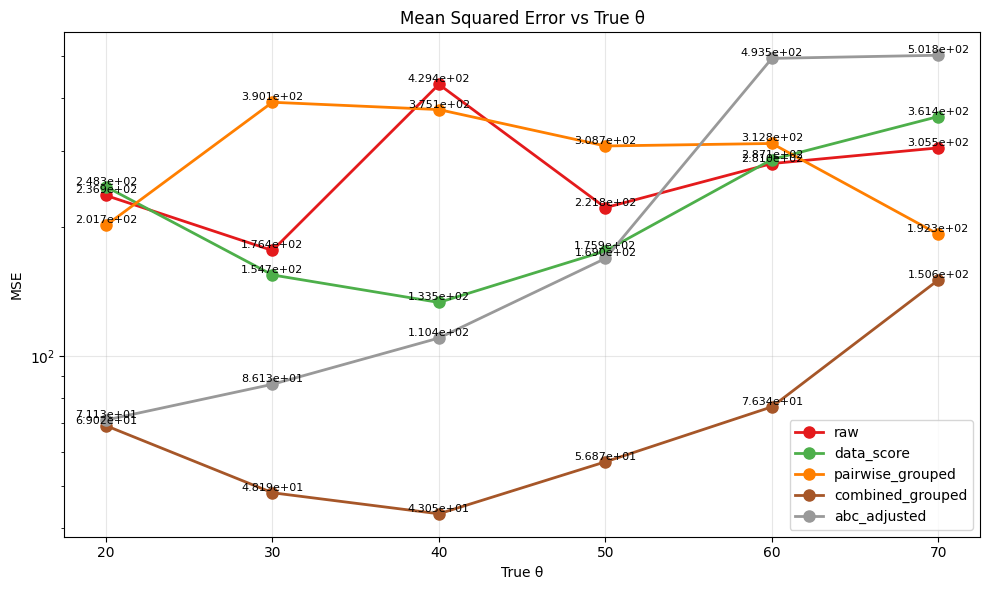


DETAILED COMPUTATIONAL COST BREAKDOWN
Method               Avg Training (s)   Avg Inference (s)  Avg Total (s)   Training Samples
----------------------------------------------------------------------------------------------------
raw                  3.144460           0.828175           3.972635        5,000          
data_score           1.672966           0.870865           2.543831        5,000          
pairwise_grouped     2.022435           0.848631           2.871066        5,000          
combined_grouped     0.299768           0.844914           1.144682        5,000          
abc_adjusted         0.000000           23.770839          23.770839       1,000          
----------------------------------------------------------------------------------------------------
Note: Training cost is amortized over training samples for neural methods
      ABC methods have zero training cost but higher inference cost
Plotting cost analysis...


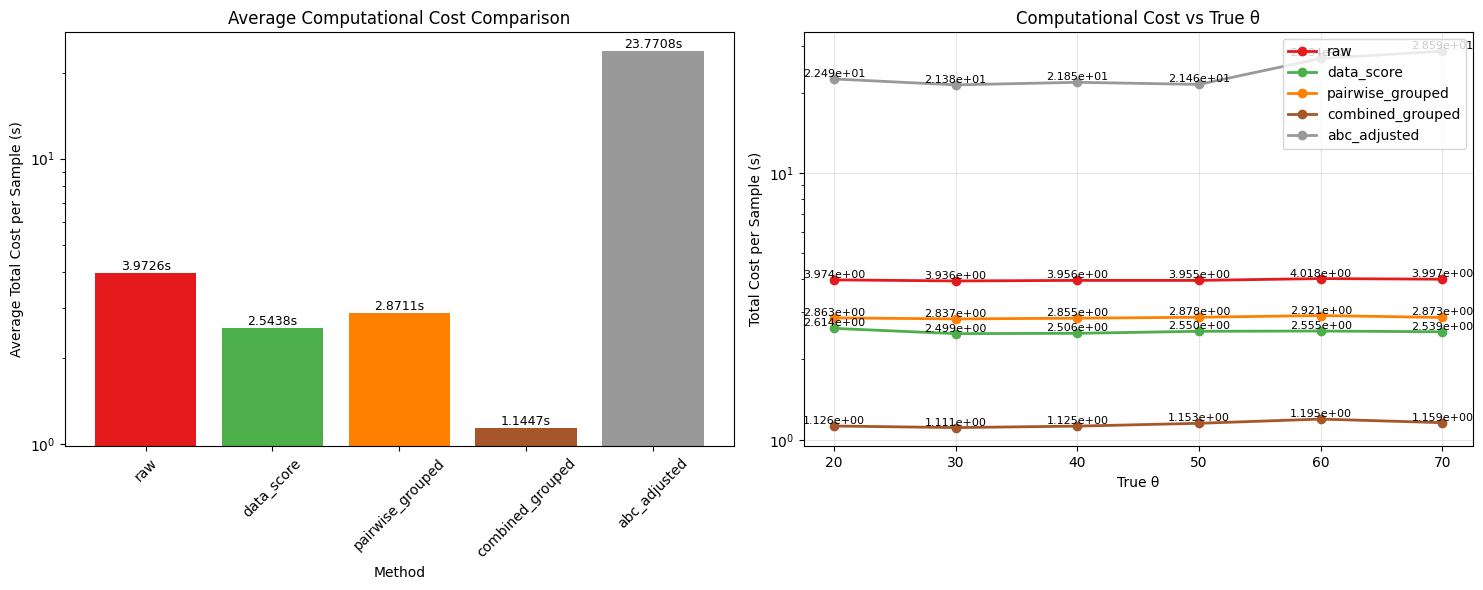

Plotting relative efficiency...


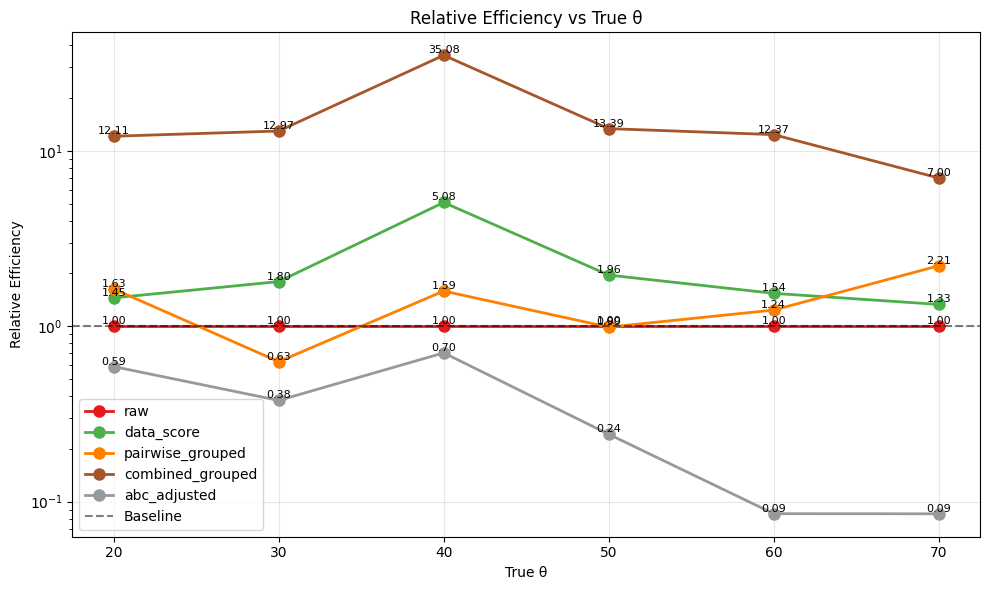


Relative Efficiency Summary (Baseline: raw):
------------------------------------------------------------
raw                 : Average = 1.000
data_score          : Average = 2.191
pairwise_grouped    : Average = 1.380
combined_grouped    : Average = 15.486
abc_adjusted        : Average = 0.347


In [107]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_results(mse_results):
    """Plot MSE results separately, with value annotations"""
    plt.figure(figsize=(10, 6))
    colors = plt.cm.Set1(np.linspace(0, 1, len(mse_results)))
    
    for i, (method_name, method_mse) in enumerate(mse_results.items()):
        thetas = sorted(method_mse.keys())
        mses = [method_mse[theta] for theta in thetas]
        plt.plot(thetas, mses, 'o-', label=method_name, linewidth=2, color=colors[i], markersize=8)
        # 在每个点上显示数值
        for x, y in zip(thetas, mses):
            plt.text(x, y, f"{y:.3e}", ha='center', va='bottom', fontsize=8)
        
    plt.xlabel('True θ')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error vs True θ')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

def print_detailed_cost_table(results):
    """Print detailed cost breakdown table"""
    print("\n" + "="*100)
    print("DETAILED COMPUTATIONAL COST BREAKDOWN")
    print("="*100)
    methods = list(results.keys())
    print(f"{'Method':<20} {'Avg Training (s)':<18} {'Avg Inference (s)':<18} {'Avg Total (s)':<15} {'Training Samples':<15}")
    print("-" * 100)
    
    for method_name, method_results in results.items():
        training_time = method_results['training_time']
        n_training_samples = method_results['n_training_samples']
        inference_times = method_results['inference_times']
        avg_inference = np.mean(inference_times)
        training_cost_per_sample = training_time / n_training_samples if n_training_samples > 0 else 0
        total_cost = training_cost_per_sample + avg_inference
        print(f"{method_name:<20} {training_cost_per_sample:<18.6f} {avg_inference:<18.6f} {total_cost:<15.6f} {n_training_samples:<15,}")
    
    print("-" * 100)
    print("Note: Training cost is amortized over training samples for neural methods")
    print("      ABC methods have zero training cost but higher inference cost")

def plot_cost_results(timing_results):
    """Plot only the two main cost charts, with annotations"""
    plt.figure(figsize=(15, 6))
    methods = list(timing_results.keys())
    avg_costs = [np.mean(list(timing_results[method].values())) for method in methods]
    colors = plt.cm.Set1(np.linspace(0, 1, len(methods)))
    
    # 1. 平均总成本柱状图
    plt.subplot(1, 2, 1)
    bars = plt.bar(methods, avg_costs, color=colors)
    plt.xlabel('Method')
    plt.ylabel('Average Total Cost per Sample (s)')
    plt.title('Average Computational Cost Comparison')
    plt.xticks(rotation=45)
    plt.yscale('log')
    for bar, cost in zip(bars, avg_costs):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{cost:.4f}s', ha='center', va='bottom', fontsize=9)

    # 2. 成本随θ变化的线图
    plt.subplot(1, 2, 2)
    for i, (method_name, method_cost) in enumerate(timing_results.items()):
        thetas = sorted(method_cost.keys())
        costs = [method_cost[theta] for theta in thetas]
        plt.plot(thetas, costs, 'o-', label=method_name, linewidth=2, color=colors[i], markersize=6)
        for x, y in zip(thetas, costs):
            plt.text(x, y, f"{y:.3e}", ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('True θ')
    plt.ylabel('Total Cost per Sample (s)')
    plt.title('Computational Cost vs True θ')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

def plot_relative_efficiency(mse_results, timing_results, baseline_method=None):
    """Plot relative efficiency line chart only, with annotations"""
    if baseline_method is None:
        baseline_method = list(mse_results.keys())[0]
    
    relative_efficiency_results = {}
    thetas = sorted(mse_results[baseline_method].keys())
    for method_name in mse_results.keys():
        relative_efficiency_results[method_name] = {}
        for theta in thetas:
            baseline_mse = mse_results[baseline_method][theta]
            baseline_cost = timing_results[baseline_method][theta]
            method_mse = mse_results[method_name][theta]
            method_cost = timing_results[method_name][theta]
            relative_efficiency = (baseline_mse / method_mse) * (baseline_cost / method_cost)
            relative_efficiency_results[method_name][theta] = relative_efficiency
    
    plt.figure(figsize=(10, 6))
    colors = plt.cm.Set1(np.linspace(0, 1, len(relative_efficiency_results)))
    for i, (method_name, method_data) in enumerate(relative_efficiency_results.items()):
        thetas_sorted = sorted(method_data.keys())
        efficiencies = [method_data[theta] for theta in thetas_sorted]
        plt.plot(thetas_sorted, efficiencies, 'o-', 
                 label=method_name, linewidth=2, color=colors[i], markersize=8)
        for x, y in zip(thetas_sorted, efficiencies):
            plt.text(x, y, f"{y:.2f}", ha='center', va='bottom', fontsize=8)
    
    plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Baseline')
    plt.xlabel('True θ')
    plt.ylabel('Relative Efficiency')
    plt.title('Relative Efficiency vs True θ')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    print(f"\nRelative Efficiency Summary (Baseline: {baseline_method}):")
    print("-" * 60)
    for method_name, method_data in relative_efficiency_results.items():
        avg_eff = np.mean(list(method_data.values()))
        print(f"{method_name:20}: Average = {avg_eff:.3f}")
    
    return relative_efficiency_results

def analyze_and_plot_all_results(results):
    """Complete analysis with MSE, simplified cost, and relative efficiency plots"""
    filtered_results = {k: v for k, v in results.items() if k != 'abc'}
    mse_results, timing_results = analyze_results(filtered_results)
    
    print("Plotting MSE results...")
    plot_mse_results(mse_results)
    print_detailed_cost_table(filtered_results)
    print("Plotting cost analysis...")
    plot_cost_results(timing_results)
    print("Plotting relative efficiency...")
    relative_efficiency_results = plot_relative_efficiency(mse_results, timing_results, baseline_method='raw')
    return mse_results, timing_results, relative_efficiency_results

# 使用示例
mse_results, timing_results, relative_efficiency_results = analyze_and_plot_all_results(experiment_results)
